# Зображення як багтовимірні масиви та підготовка зображеннь до подальшого аналіщу.

In [8]:
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt

import skimage  # scikit-image

Корекція фонової інтенсивності

Оформлення всіх кроків корекції фонової інтенсивності у функцію

In [1]:
def background_correction(input_img:np.ndarray, background_percentile:float=1):
    back_int = np.percentile(input_img, background_percentile)
    corr_img = input_img - back_int
    corr_img = corr_img.clip(min=0)
    return corr_img.astype(input_img.dtype)

NameError: name 'np' is not defined

In [25]:
import numpy as np
import matplotlib.pyplot as plt

def select_region(input_img:np.ndarray,y1,y2,x1,x2):
    crop_image = input_img[y1:y2,x1:x2]
    plt.figure(figsize=(5,5))
    plt.imshow(crop_image, cmap='Greys_r')
    return crop_image.astype(input_img.dtype)

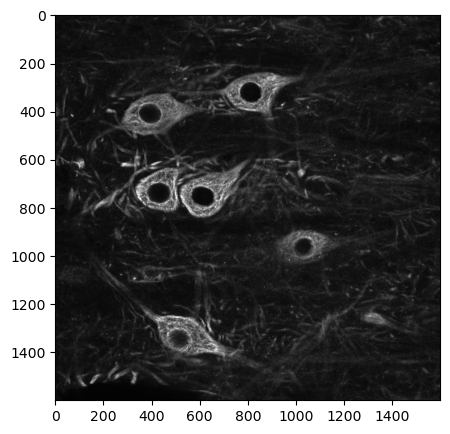

In [5]:
import tifffile as tiff
image = tiff.imread('../demo_data/2D_grey_matter_neurofilaments.tif')
plt.figure(figsize=(5,5))
plt.imshow(image, cmap='Greys_r')

In [ ]:
def background_correction(input_img:np.ndarray, background_percentile:float =1):
    back_int = np.percentile(input_img, background_percentile)
    corr_img = input_img - back_int
    corr_img = corr_img.clip(min=0)
    return corr_img.astype(input_img.dtype)

Acridine Orange images were acquired using a 20× objective on the Cytation 5 imaging system. Image acquisition utilized the following LED cube channels:
1. GFP channel (excitation/emission = 469/525 nm) for the visualization of nuclei, nucleoli, and cytoplasm;
2. PI channel (excitation/emission = 531/647 nm) for the detection of acidic vesicles.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def crop_function(input_img: np.ndarray, x1, x2, y1, y2):
    
    crop_image = input_img[y1:y2, x1:x2]
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(input_img)
    
    rect = patches.Rectangle(
        (x1, y1), x2 - x1, y2 - y1, 
        linewidth=2, edgecolor='red', facecolor='none'
    )
    
    ax[0].add_patch(rect)
    ax[0].set_title("Original Image (ROI highlighted)")
    
    ax[1].imshow(crop_image)
    ax[1].set_title("Cropped ROI")
    
    plt.tight_layout()
    plt.show()
    
    return crop_image.astype(input_img.dtype)

In [10]:
import tifffile as tiff 
GFP =  tiff.imread("/Users/romankoval/BioInUA_2025_img_analysis/course_data/my_data/B8_01_1_9_GFP_001.tif")
PI =  tiff.imread("/Users/romankoval/BioInUA_2025_img_analysis/course_data/my_data/B8_01_2_9_Propidium Iodide_001.tif")

In [ ]:

import numpy as np
import matplotlib.pyplot as plt

def background_correction(input_img: np.ndarray, background_percentile: float = 1):
  

    back_int = np.percentile(input_img, background_percentile)

    corr_img = input_img - back_int
    corr_img = corr_img.clip(min=0)

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(input_img, cmap='Greys_r')
    ax[0].set_title("Original Image")

    ax[1].imshow(corr_img, cmap='Greys_r')
    ax[1].set_title(f"Background-corrected (−{background_percentile}th percentile)")


    plt.tight_layout()
    plt.show()

    return corr_img.astype(input_img.dtype)


2. Shadding correction

In [32]:
import numpy as np
from tifffile import imread, imwrite
from scipy.ndimage import gaussian_filter

def estimate_flatfield(image_paths, sigma_px=60):
    """
    image_paths: list of TIFF paths from the SAME channel (10–20+ fields).
    sigma_px: Gaussian blur in pixels (50–100 typical for HCS fields).
    returns: float32 flat-field with median ~ 1.0
    """
    stack = [imread(p).astype(np.float32) for p in image_paths]
    med = np.median(np.stack(stack, axis=0), axis=0)       # multiplicative pattern
    ff  = gaussian_filter(med, sigma=sigma_px)             # smooth to illumination field
    # guard against zeros and normalize
    ff[ff <= 1e-6] = np.median(ff[ff > 0])
    ff /= np.median(ff)
    return ff.astype(np.float32)

In [43]:
from pathlib import Path

# 1. Get ~10–20 representative fields from one channel (e.g., GFP)
data_dir = Path("/Users/romankoval/data/GFP_train/")
image_paths = sorted(data_dir.glob("*.tif"))[:20]  # adjust number and extension

# 2. Estimate flat-field
ff = estimate_flatfield(image_paths, sigma_px=60)




In [44]:
def apply_flatfield(img, ff):
    """
    Divide by flat-field and rescale back to original dtype range (16-bit safe).
    """
    out = img.astype(np.float32) / ff
    if np.issubdtype(img.dtype, np.integer):
        info = np.iinfo(img.dtype)
        out = np.clip(out, 0, info.max).astype(img.dtype)
    else:
        out = out.astype(img.dtype)
    return out

In [48]:
img_corr = GFP.astype(np.float32) / ff
img_corr = np.clip(img_corr, 0, np.iinfo(np.uint16).max).astype(np.uint16)

In [47]:
apply_flatfield(GFP, ff)


array([[ 6863,  6746,  6712, ...,  5014,  4554,  4586],
       [ 6712,  6746,  6561, ...,  4649,  5062,  4602],
       [ 6611,  6443,  6863, ...,  4887,  4983,  5014],
       ...,
       [ 9934, 10611, 10763, ...,  6024,  5788,  5838],
       [10188,  9951, 10865, ...,  5636,  5855,  5551],
       [ 9934, 10357, 10780, ...,  5788,  6108,  5889]],
      shape=(904, 1224), dtype=uint16)

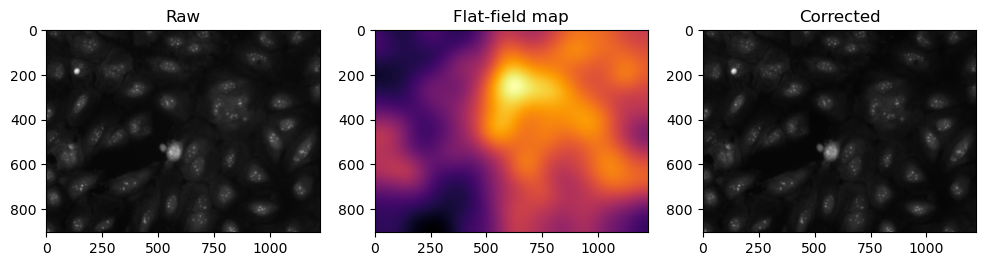

In [50]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(GFP, cmap='gray'); plt.title("Raw")

plt.subplot(1,3,2)
plt.imshow(ff, cmap='inferno'); plt.title("Flat-field map")

plt.subplot(1,3,3)
plt.imshow(img_corr, cmap='gray'); plt.title("Corrected")
plt.show()


3. Background correction

In [23]:
import numpy as np
import tifffile as tiff
import skimage
import matplotlib.pyplot as plt

def background_correction(input_img: np.ndarray, radius: int = 50):
    """
    Performs background correction using rolling-ball algorithm from scikit-image.
    Visualizes raw, background, and corrected images side-by-side.
    """
    # Compute background
    background_img = skimage.restoration.rolling_ball(input_img, radius=radius)
    corr_img = input_img - background_img
    corr_img = corr_img.clip(min=0)
    
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].imshow(input_img, cmap='gray')
    axes[0].set_title('Raw image')

    axes[1].imshow(background_img, cmap='gray')
    axes[1].set_title('Background')

    axes[2].imshow(corr_img, cmap='gray')
    axes[2].set_title('Corrected')

    plt.tight_layout()
    plt.show()
    
    return corr_img.astype(input_img.dtype)


?Чому при збільшенні радіусу подовжується час виконання команди, для 300 = майже 8 хв?

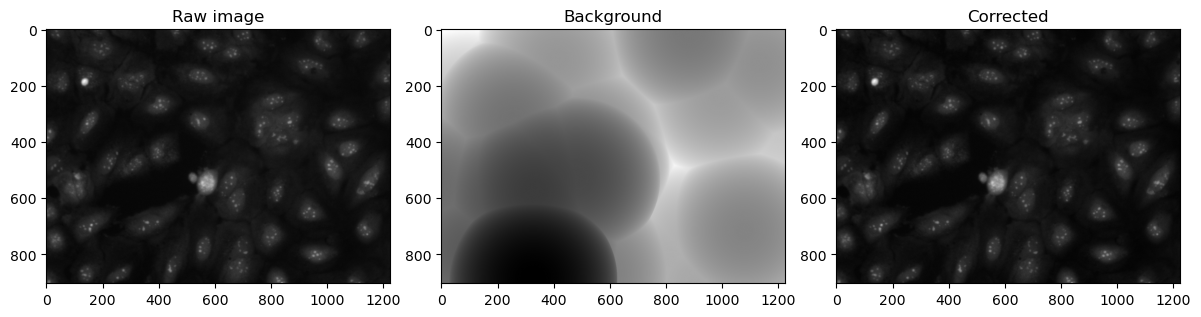

In [31]:
GFP_cor = background_correction(GFP, 300)

array([[6160, 6000, 6880, ..., 7520, 6960, 7424],
       [5968, 6064, 6032, ..., 7952, 7280, 7568],
       [5952, 6000, 5872, ..., 7360, 7008, 7072],
       ...,
       [5136, 5600, 5168, ..., 4976, 4688, 5152],
       [5568, 4896, 5456, ..., 4640, 4816, 4736],
       [5312, 5344, 5216, ..., 4400, 4704, 4976]],
      shape=(200, 200), dtype=uint16)

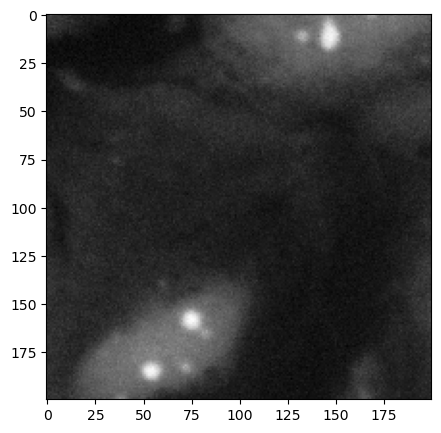

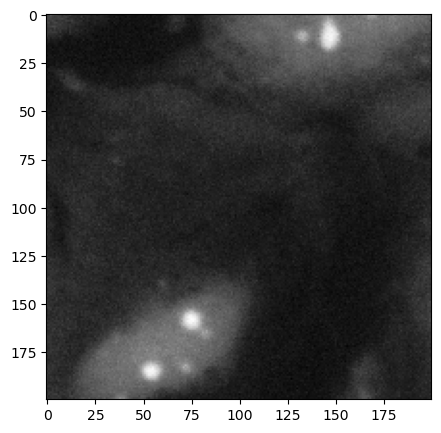

In [30]:
select_region(GFP_cor, 700,900, 200,400)
select_region(GFP, 700,900, 200,400)

In [2]:
import numpy as np
from tifffile import imread, imwrite
from scipy.ndimage import gaussian_filter
from glob import glob
from pathlib import Path

def estimate_flat_dark(image_paths, sigma_px=60):
    """Estimate flat-field (multiplicative) and dark (additive) from many frames."""
    stack = [imread(p).astype(np.float32) for p in image_paths]
    med  = np.median(np.stack(stack, axis=0), axis=0)   # robust to cells moving
    dark = np.percentile(np.stack(stack, axis=0), 1, axis=0)  # near-min as additive
    flat = gaussian_filter(med, sigma=sigma_px)         # smooth illumination field
    flat = np.clip(flat, np.median(flat[flat>0])*0.1, None)   # guard against zeros
    # normalize flat so its median is 1
    flat /= np.median(flat)
    return flat.astype(np.float32), dark.astype(np.float32)

def apply_correction(img, flat, dark):
    corr = (img.astype(np.float32) - dark) / flat
    # rescale back to original dtype range
    corr -= corr.min()
    corr *= (np.iinfo(img.dtype).max / max(1e-6, corr.max()))

    return corr.astype(np.uint16)

In [2]:
paths = sorted(glob("/Users/romankoval/data/GFP_train/*.tif"))
flat, dark = estimate_flat_dark(paths, sigma_px=60)

In [62]:
img = tiff.imread("/Users/romankoval/BioInUA_2025_img_analysis/course_data/my_data/B8_01_1_9_GFP_001.tif")
corr_image = apply_correction(img, flat, dark)


Text(0.5, 1.0, 'Corrected Image')

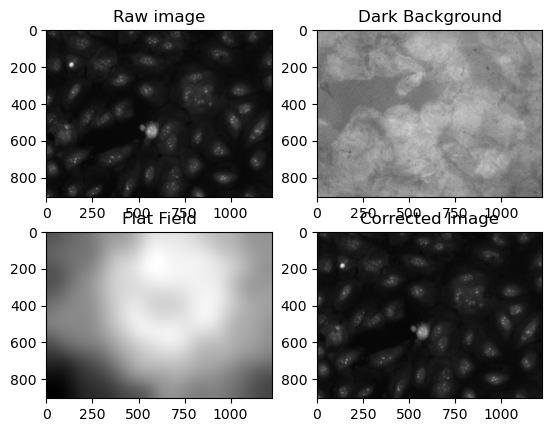

In [ ]:
fig, axes = plt.subplots(2, 2)
axes[0, 0].imshow(img, cmap='gray')
axes[0, 0].set_title('Raw image')

axes[0, 1].imshow(dark, cmap='gray')
axes[0, 1].set_title('Dark Background')

axes[1, 0].imshow(flat, cmap='gray')
axes[1, 0].set_title('Flat Field')

axes[1, 1].imshow(corr_image, cmap='gray')
axes[1, 1].set_title('Corrected Image')

How change different env more or less automatically?

In [1]:
!pip install cellpose

  Using cached cellpose-4.0.7-py3-none-any.whl.metadata (22 kB)
  Using cached natsort-8.4.0-py3-none-any.whl.metadata (21 kB)
  Using cached opencv_python_headless-4.12.0.88-cp37-abi3-macosx_13_0_arm64.whl.metadata (19 kB)
  Using cached roifile-2025.5.10-py3-none-any.whl.metadata (5.9 kB)
  Using cached segment_anything-1.0-py3-none-any.whl.metadata (487 bytes)
  Using cached filelock-3.20.0-py3-none-any.whl.metadata (2.1 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
Using cached cellpose-4.0.7-py3-none-any.whl (212 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 MB 3.4 MB/s  0:00:21m0:00:0100:01m
Using cached sympy-1.14.0-py3-none-any.whl (6.3 MB)
Using cached mpmath-1.3.0-py3-none-any.whl (536 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 658.5/658.5 kB 6.9 MB/s  0:00:00
Using cached filelock-3.20.0-py3-none-any.whl (16 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 3.0 MB/s

In [14]:
from pathlib import Path
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt
from cellpose import models, io, plot
from cellpose.models import CellposeModel


# -------- settings --------
img_dir   = Path("/Users/romankoval/BioInUA_2025_img_analysis/course_data/my_data/")
exts      = {".tif", ".tiff"}
channels  = (0, 0)        # 2D grayscale: cytoplasm=0, nucleus=0
diameter  = None          # let Cellpose estimate; set e.g. 12–18 if you know nuclei size
gpu       = True          # set False if no GPU
normalize = True          # normalize each image to [0,1] before inference

# -------- collect files --------
files = sorted([p for p in img_dir.rglob("*") if p.suffix.lower() in exts])
if not files:
    raise FileNotFoundError(f"No images with {tuple(exts)} found in {img_dir}")

# -------- helper: read & sanity-check 2D --------
def read_2d(fp: Path, normalize01=True):
    img = tiff.imread(str(fp))
    if img.ndim != 2:
        raise ValueError(f"{fp.name} is not 2D; got shape {img.shape}")
    if normalize01:
        img = img.astype(np.float32, copy=False)
        mx, mn = float(img.max()), float(img.min())
        if mx > mn:
            img = (img - mn) / (mx - mn)
        else:
            img[:] = 0.0
    return img

# -------- load all 2D images --------
imgs = [read_2d(f, normalize01=normalize) for f in files]

# -------- cellpose model --------
io.logger_setup()
# Load the pre-trained cytoplasm model
model_cyto = CellposeModel(gpu = True, model_type='cyto')

# Load the pre-trained nuclei model
model_nuclei = CellposeModel(gpu = True, model_type='nuclei')



2025-10-13 10:45:46,744 [INFO] WRITING LOG OUTPUT TO /Users/romankoval/.cellpose/run.log
2025-10-13 10:45:46,744 [INFO] 
cellpose version: 	4.0.7 
platform:       	darwin 
python version: 	3.13.7 
torch version:  	2.8.0
2025-10-13 10:45:46,745 [WARNING] model_type argument is not used in v4.0.1+. Ignoring this argument...
2025-10-13 10:45:46,749 [INFO] ** TORCH MPS version installed and working. **
2025-10-13 10:45:46,749 [INFO] >>>> using GPU (MPS)
2025-10-13 10:45:48,183 [INFO] >>>> loading model /Users/romankoval/.cellpose/models/cpsam
2025-10-13 10:45:48,868 [WARNING] model_type argument is not used in v4.0.1+. Ignoring this argument...
2025-10-13 10:45:48,882 [INFO] ** TORCH MPS version installed and working. **
2025-10-13 10:45:48,883 [INFO] >>>> using GPU (MPS)
2025-10-13 10:45:49,901 [INFO] >>>> loading model /Users/romankoval/.cellpose/models/cpsam


2025-10-13 10:31:01,912 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
2025-10-13 10:31:37,544 [INFO] 100%|##########| 2/2 [00:35<00:00, 17.81s/it]


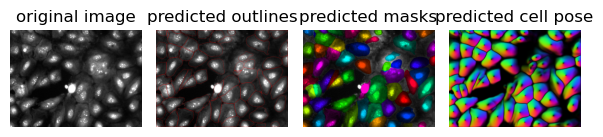

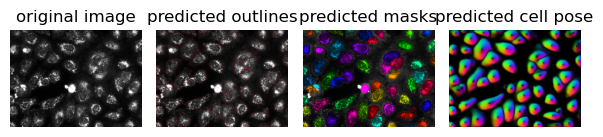

In [11]:


# batch eval: pass the whole list
masks_list, flows_list, styles = model.eval(
    imgs,
    diameter=diameter,
    flow_threshold=None,
    channels=channels
)

# -------- save & preview --------
out_dir = img_dir / "_cellpose_out"
out_dir.mkdir(exist_ok=True, parents=True)

for fp, img, masks, flows in zip(files, imgs, masks_list, flows_list):
    # save masks as uint16 label image
    tiff.imwrite(str(out_dir / f"{fp.stem}_cp_masks.tif"),
                 masks.astype(np.uint16), photometric="minisblack")

    # quick overlay
    fig = plt.figure(figsize=(6,5))
    try:
        flow_show = flows[0] if isinstance(flows, (list, tuple)) else flows
        plot.show_segmentation(fig, img, masks, flow_show, channels=channels)
    except Exception:
        overlay = plot.mask_overlay(img, masks)
        plt.imshow(overlay)
        plt.title("Mask overlay"); plt.axis("off")
    plt.tight_layout(); plt.show()


In [ ]:
from pathlib import Path
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt
from cellpose import models, io, plot

# ==== Settings ====
img_dir   = Path("/Users/romankoval/BioInUA_2025_img_analysis/course_data/my_data")
exts      = {".tif", ".tiff"}
channels  = (0, 0)        # single-channel grayscale
diameters = {"cyto": None, "nuclei": None}  # set numbers if you know sizes
gpu       = True
normalize = True
preview_n = 1             # set >0 to preview first N images per model

# ==== Collect files ====
files = sorted([p for p in img_dir.rglob("*") if p.suffix.lower() in exts])
if not files:
    raise FileNotFoundError(f"No images with {tuple(exts)} found in {img_dir}")




In [ ]:
# ==== Helpers ====
def read_2d(fp: Path, norm01=True):
    img = tiff.imread(str(fp))
    if img.ndim != 2:
        raise ValueError(f"{fp.name} is not 2D; got {img.shape}")
    if norm01:
        img = img.astype(np.float32, copy=False)
        mn, mx = float(img.min()), float(img.max())
        img = (img - mn) / (mx - mn) if mx > mn else np.zeros_like(img, dtype=np.float32)
    return img

def unpack_eval(out, n_imgs):
    """Handle Cellpose versions returning 3 or 4 items (or just masks)."""
    if isinstance(out, tuple):
        if len(out) == 4:
            return out  # masks_list, flows_list, styles, diams
        if len(out) == 3:
            masks_list, flows_list, styles = out
            diams = [None] * len(masks_list)
            return masks_list, flows_list, styles, diams
    # very old: may return only masks
    masks_list = out
    flows_list = [None] * n_imgs
    styles = None
    diams = [None] * n_imgs
    return masks_list, flows_list, styles, diams

In [17]:
# ==== Load images ====
imgs = [read_2d(f, norm01=normalize) for f in files]

# ==== Run both models ====
io.logger_setup()
out_root = img_dir / "_cellpose_out"
out_root.mkdir(parents=True, exist_ok=True)

for model_type in ("cyto", "nuclei"):
    print(f"\n>>> Running Cellpose model: {model_type}")
    model = models.CellposeModel(gpu=gpu, model_type=model_type)

    out = model.eval(
        imgs,
        diameter=diameters.get(model_type),
        flow_threshold=None,
        channels=channels
    )
    masks_list, flows_list, styles, diams = unpack_eval(out, n_imgs=len(imgs))

    # per-model output dir
    out_dir = out_root / model_type
    out_dir.mkdir(exist_ok=True, parents=True)

    # save & (optional) preview
    for i, (fp, img, masks, flows) in enumerate(zip(files, imgs, masks_list, flows_list)):
        # save label masks
        tiff.imwrite(
            str(out_dir / f"{fp.stem}_cp_{model_type}_masks.tif"),
            masks.astype(np.uint16),
            photometric="minisblack"
        )

        # optional quick preview for first N images
        if i < preview_n:
            plt.figure(figsize=(6, 5))
            try:
                flow_show = flows[0] if isinstance(flows, (list, tuple)) else flows
                plot.show_segmentation(plt.gcf(), img, masks, flow_show, channels=channels)
            except Exception:
                overlay = plot.mask_overlay(img, masks)
                plt.imshow(overlay); plt.title(f"{fp.name} • {model_type}"); plt.axis("off")
            plt.tight_layout(); plt.show()

    print(f"Saved masks to: {out_dir}")

2025-10-13 10:54:53,149 [INFO] WRITING LOG OUTPUT TO /Users/romankoval/.cellpose/run.log
2025-10-13 10:54:53,149 [INFO] 
cellpose version: 	4.0.7 
platform:       	darwin 
python version: 	3.13.7 
torch version:  	2.8.0

>>> Running Cellpose model: cyto
2025-10-13 10:54:53,150 [WARNING] model_type argument is not used in v4.0.1+. Ignoring this argument...
2025-10-13 10:54:53,155 [INFO] ** TORCH MPS version installed and working. **
2025-10-13 10:54:53,155 [INFO] >>>> using GPU (MPS)
2025-10-13 10:54:54,583 [INFO] >>>> loading model /Users/romankoval/.cellpose/models/cpsam
2025-10-13 10:54:55,308 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
2025-10-13 10:56:05,057 [INFO] 100%|##########| 4/4 [01:09<00:00, 17.44s/it]
Saved masks to: /Users/romankoval/BioInUA_2025_img_analysis/course_data/my_data/_cellpose_out/cyto

>>> Running Cellpose model: nuclei
2025-10-13 10:56:05,077 [WARNING] model_type argument is not used 

In [18]:
from pathlib import Path
from typing import Iterable, Dict, Optional, Tuple, List
import numpy as np
import tifffile as tiff
from cellpose import models, io, plot

def cell_segment(
    img_dir: Path,
    out_root: Optional[Path] = None,
    model_types: Iterable[str] = ("nuclei",),         # ("cyto", "nuclei") to run both
    channels: Tuple[int, int] = (0, 0),               # 2D grayscale
    diameters: Optional[Dict[str, Optional[float]]] = None,  # e.g., {"nuclei": 14, "cyto": 30}
    normalize01: bool = True,                         # per-image min-max → [0,1]
    gpu: bool = True,
    preview_n: int = 0                                # show first N overlays per model
) -> Dict[str, List[Path]]:
    """
    Segment 2D TIF/TIFF images with Cellpose.

    Parameters
    ----------
    img_dir : Path
        Folder with input *.tif/*.tiff (searched recursively).
    out_root : Path | None
        Where to write outputs; default = img_dir/'_cellpose_out'.
    model_types : iterable of {'cyto','nuclei'}
        Which Cellpose models to run.
    channels : (int,int)
        Cellpose channel mapping; for single-channel grayscale keep (0,0).
    diameters : dict[str, float|None] | None
        Optional per-model diameter; None lets Cellpose estimate.
    normalize01 : bool
        If True, min-max scale each image to [0,1].
    gpu : bool
        Enable GPU if available.
    preview_n : int
        If >0, show quick overlays for first N images per model.

    Returns
    -------
    outputs : dict
        Map model_type -> list of paths to saved mask TIFFs.
    """
    io.logger_setup()

    img_dir = Path(img_dir).expanduser().resolve()
    if not img_dir.exists():
        raise FileNotFoundError(f"Input folder does not exist: {img_dir}")

    exts = {".tif", ".tiff"}
    files = sorted(p for p in img_dir.rglob("*") if p.is_file() and p.suffix.lower() in exts)
    if not files:
        raise FileNotFoundError(f"No images with {tuple(exts)} found in {img_dir}")

    if out_root is None:
        out_root = img_dir / "_cellpose_out"
    out_root.mkdir(parents=True, exist_ok=True)

    if diameters is None:
        diameters = {}
    model_types = tuple(model_types)

    def read_2d(fp: Path) -> np.ndarray:
        img = tiff.imread(str(fp))
        if img.ndim != 2:
            raise ValueError(f"{fp.name} is not 2D; got shape {img.shape}")
        if normalize01:
            img = img.astype(np.float32, copy=False)
            mn, mx = float(img.min()), float(img.max())
            if mx > mn:
                img = (img - mn) / (mx - mn)
            else:
                img = np.zeros_like(img, dtype=np.float32)
        return img

    def unpack_eval(out, n_imgs):
        # Handle different Cellpose versions (3 vs 4 return values vs just masks)
        if isinstance(out, tuple):
            if len(out) == 4:
                return out  # masks_list, flows_list, styles, diams
            if len(out) == 3:
                masks_list, flows_list, styles = out
                diams = [None] * len(masks_list)
                return masks_list, flows_list, styles, diams
        masks_list = out
        flows_list = [None] * n_imgs
        styles = None
        diams = [None] * n_imgs
        return masks_list, flows_list, styles, diams

    # Load all images (keeps code simple; for huge sets, stream per-image instead)
    imgs = [read_2d(f) for f in files]

    results: Dict[str, List[Path]] = {}

    for model_type in model_types:
        out_dir = out_root / model_type
        out_dir.mkdir(parents=True, exist_ok=True)

        model = models.CellposeModel(gpu=gpu, model_type=model_type)
        out = model.eval(
            imgs,
            diameter=diameters.get(model_type),
            flow_threshold=None,
            channels=channels
        )
        masks_list, flows_list, styles, diams = unpack_eval(out, n_imgs=len(imgs))

        saved_paths: List[Path] = []
        for i, (fp, img, masks, flows) in enumerate(zip(files, imgs, masks_list, flows_list)):
            save_path = out_dir / f"{fp.stem}_cp_{model_type}_masks.tif"
            tiff.imwrite(str(save_path), masks.astype(np.uint16), photometric="minisblack")
            saved_paths.append(save_path)

            if i < preview_n:
                import matplotlib.pyplot as plt
                try:
                    flow_show = flows[0] if isinstance(flows, (list, tuple)) else flows
                    plot.show_segmentation(plt.gcf(), img, masks, flow_show, channels=channels)
                except Exception:
                    overlay = plot.mask_overlay(img, masks)
                    plt.imshow(overlay); plt.title(f"{fp.name} • {model_type}"); plt.axis("off")
                plt.tight_layout(); plt.show()

        results[model_type] = saved_paths

    return results


2025-10-13 11:03:31,867 [INFO] WRITING LOG OUTPUT TO /Users/romankoval/.cellpose/run.log
2025-10-13 11:03:31,867 [INFO] 
cellpose version: 	4.0.7 
platform:       	darwin 
python version: 	3.13.7 
torch version:  	2.8.0
2025-10-13 11:03:31,936 [WARNING] model_type argument is not used in v4.0.1+. Ignoring this argument...
2025-10-13 11:03:31,940 [INFO] ** TORCH MPS version installed and working. **
2025-10-13 11:03:31,940 [INFO] >>>> using GPU (MPS)
2025-10-13 11:03:33,352 [INFO] >>>> loading model /Users/romankoval/.cellpose/models/cpsam
2025-10-13 11:03:34,026 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
2025-10-13 11:07:08,398 [INFO] 100%|##########| 12/12 [03:34<00:00, 17.86s/it]


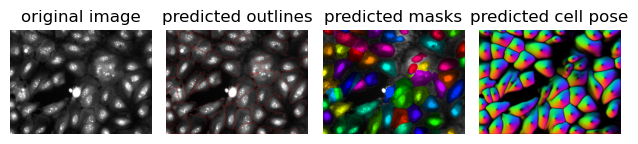

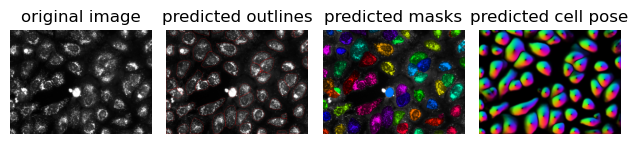

2025-10-13 11:07:09,790 [WARNING] model_type argument is not used in v4.0.1+. Ignoring this argument...
2025-10-13 11:07:09,799 [INFO] ** TORCH MPS version installed and working. **
2025-10-13 11:07:09,799 [INFO] >>>> using GPU (MPS)
2025-10-13 11:07:11,380 [INFO] >>>> loading model /Users/romankoval/.cellpose/models/cpsam
2025-10-13 11:07:12,047 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
2025-10-13 11:07:12,049 [INFO] 0%|          | 0/12 [00:00<?, ?it/s]
2025-10-13 11:08:33,515 [WARNING] Resizing is deprecated in v4.0.1+
2025-10-13 11:08:33,571 [INFO] 8%|8         | 1/12 [01:21<14:56, 81.52s/it]
2025-10-13 11:10:02,986 [WARNING] Resizing is deprecated in v4.0.1+
2025-10-13 11:10:03,035 [INFO] 17%|#6        | 2/12 [02:50<14:21, 86.19s/it]
2025-10-13 11:11:30,945 [WARNING] Resizing is deprecated in v4.0.1+
2025-10-13 11:11:30,994 [INFO] 25%|##5       | 3/12 [04:18<13:02, 87.00s/it]
2025-10-13 11:12:59,901 [WARNI

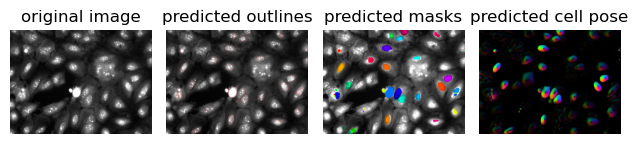

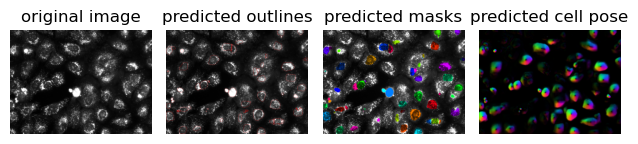

{'cyto': 12, 'nuclei': 12}


In [22]:
from pathlib import Path

outputs = cell_segment(
    img_dir=Path("./my_data"),
    model_types=("cyto","nuclei"),
    diameters={"nuclei": 14, "cyto": 30},  # or leave None to auto
    channels=(0,0),
    gpu=True,
    preview_n=2
)
print({k: len(v) for k,v in outputs.items()})


Pixel binning

Compared 1×1 (full resolution) vs 2×2 binning (pixel averaging).

Result: No detectable loss of morphological profile quality with 2×2 binning (Figure 5C).

Benefit:

4× reduction in image file size,

Significant reduction in data storage and compute time.

Recommendation: Use 2×2 binning whenever possible.

In [ ]:
!pip install cellpose


  Using cached cellpose-4.0.7-py3-none-any.whl.metadata (22 kB)
  Using cached natsort-8.4.0-py3-none-any.whl.metadata (21 kB)
  Using cached opencv_python_headless-4.12.0.88-cp37-abi3-macosx_13_0_arm64.whl.metadata (19 kB)
  Using cached roifile-2025.5.10-py3-none-any.whl.metadata (5.9 kB)
  Using cached segment_anything-1.0-py3-none-any.whl.metadata (487 bytes)
  Using cached filelock-3.20.0-py3-none-any.whl.metadata (2.1 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
Using cached cellpose-4.0.7-py3-none-any.whl (212 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 MB 783.9 kB/s  0:00:55m0:00:0100:04
Using cached sympy-1.14.0-py3-none-any.whl (6.3 MB)
Using cached mpmath-1.3.0-py3-none-any.whl (536 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 658.5/658.5 kB 2.3 MB/s  0:00:00
Using cached filelock-3.20.0-py3-none-any.whl (16 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 3.4 MB/

In [15]:
from my_def import cell_segment

In [12]:
help(cell_segment)

Help on function cell_segment in module my_def:

cell_segment(
    img_dir: pathlib._local.Path,
    out_root: Optional[pathlib._local.Path] = None,
    model_types: Iterable[str] = ('nuclei', 'cyto2'),
    channels: Tuple[int, int] = (0, 0),
    diameters: Optional[Dict[str, Optional[float]]] = None,
    *,
    normalization: str = 'none',
    norm_percentiles: Tuple[float, float] = (1.0, 99.0),
    projection: Optional[str] = None,
    select_channel: Optional[int] = None,
    batch_size: Optional[int] = None,
    gpu: bool = True,
    flow_threshold: Optional[float] = None,
    mask_threshold: Optional[float] = None,
    cellprob_threshold: Optional[float] = None,
    preview_n: int = 0
) -> Dict[str, List[pathlib._local.Path]]
    Segment TIFF images with Cellpose.

    Parameters
    ----------
    img_dir : Path
        Folder with input *.tif/*.tiff (searched recursively).
    out_root : Path | None
        Output root (default: <img_dir>/_cellpose_out).
    model_types : iterab

In [16]:
cell_segment(
    img_dir= "/Users/romankoval/data/flat_dark_apply",
    
)

2025-10-14 17:34:02,687 [INFO] WRITING LOG OUTPUT TO /Users/romankoval/.cellpose/run.log
2025-10-14 17:34:02,688 [INFO] 
cellpose version: 	4.0.7 
platform:       	darwin 
python version: 	3.13.7 
torch version:  	2.8.0
2025-10-14 17:34:02,709 [WARNING] model_type argument is not used in v4.0.1+. Ignoring this argument...
2025-10-14 17:34:02,710 [INFO] >>>> using CPU
2025-10-14 17:34:02,710 [INFO] >>>> using CPU
2025-10-14 17:34:03,653 [INFO] >>>> loading model /Users/romankoval/.cellpose/models/cpsam


TypeError: CellposeModel.eval() got an unexpected keyword argument 'mask_threshold'. Did you mean 'flow_threshold'?

In [1]:
pip install "cellpose<4"

Note: you may need to restart the kernel to use updated packages.


In [31]:
from pathlib import Path
from typing import Iterable, Optional, Tuple, Dict, List
import warnings
import inspect

import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt
from cellpose import models, plot, io


def cell_segment(
    img_dir: Path,
    out_root: Optional[Path] = None,
    model_types: Iterable[str] = ("nuclei", "cyto2"),
    channels: Tuple[int, int] = (0, 0),
    diameters: Optional[Dict[str, Optional[float]]] = None,
    *,
    # Normalization: "none" | "minmax" | "percentile"
    normalization: str = "none",
    norm_percentiles: Tuple[float, float] = (1.0, 99.0),
    # Non-2D handling (assume axis 0 is planes/channels if ndim==3)
    projection: Optional[str] = None,        # None | "max" | "mean"
    select_channel: Optional[int] = None,    # choose a slice from axis 0
    # Execution
    batch_size: Optional[int] = None,        # process in chunks; None = all at once
    gpu: bool = True,
    # Thresholds (some CP versions don’t support all of these)
    flow_threshold: Optional[float] = None,
    mask_threshold: Optional[float] = None,       # may not exist in your CP
    cellprob_threshold: Optional[float] = None,
    # Visualization
    preview_n: int = 0,
) -> Dict[str, List[Path]]:
    """
    Segment 2D TIFFs with Cellpose. Auto-adapts to the installed Cellpose
    by filtering unsupported eval() kwargs (e.g., mask_threshold).
    """
    io.logger_setup()

    # --- Resolve and validate paths ---
    img_dir = Path(img_dir).expanduser().resolve()
    if not img_dir.exists():
        raise FileNotFoundError(f"Input folder does not exist: {img_dir}")

    exts = {".tif", ".tiff"}
    files = sorted(p for p in img_dir.rglob("*") if p.is_file() and p.suffix.lower() in exts)
    if not files:
        raise FileNotFoundError(f"No images with {tuple(exts)} found in {img_dir}")

    if out_root is None:
        out_root = img_dir / "_cellpose_out"
    out_root = Path(out_root).expanduser().resolve()
    out_root.mkdir(parents=True, exist_ok=True)

    # --- Normalize model_types / diameters ---
    model_types = [model_types] if isinstance(model_types, str) else list(model_types)
    diameters = {} if diameters is None else dict(diameters)

    # --- GPU availability check ---
    try:
        gpu_available = models.use_gpu()
    except Exception:
        gpu_available = False
    use_gpu = bool(gpu and gpu_available)
    if gpu and not use_gpu:
        warnings.warn("GPU requested but not available; falling back to CPU.", RuntimeWarning)

    # --- Helpers ---
    def _to_float32(img: np.ndarray) -> np.ndarray:
        return img.astype(np.float32, copy=False)

    def _normalize(img: np.ndarray) -> np.ndarray:
        if normalization == "none":
            return img
        if normalization == "minmax":
            mn, mx = float(img.min()), float(img.max())
            return (img - mn) / (mx - mn) if mx > mn else np.zeros_like(img, dtype=np.float32)
        if normalization == "percentile":
            lo, hi = np.percentile(img, norm_percentiles)
            return np.clip((img - lo) / (hi - lo), 0.0, 1.0) if hi > lo else np.zeros_like(img, dtype=np.float32)
        raise ValueError(f"Unknown normalization mode: {normalization}")

    def _prepare_2d(img: np.ndarray, src_name: str) -> np.ndarray:
        if img.ndim == 2:
            return _normalize(_to_float32(img))
        if img.ndim == 3:
            arr = img
            if select_channel is not None:
                if not (0 <= select_channel < arr.shape[0]):
                    raise ValueError(f"{src_name}: select_channel={select_channel} out of range for {arr.shape}")
                arr = arr[select_channel]
            else:
                if projection is None:
                    raise ValueError(
                        f"{src_name}: not 2D (shape {img.shape}). Set select_channel or projection=('max'|'mean')."
                    )
                if projection == "max":
                    arr = arr.max(axis=0)
                elif projection == "mean":
                    arr = arr.mean(axis=0)
                else:
                    raise ValueError(f"{src_name}: unknown projection='{projection}'")
            if arr.ndim != 2:
                raise ValueError(f"{src_name}: expected 2D after selection/projection, got {arr.shape}")
            return _normalize(_to_float32(arr))
        raise ValueError(f"{src_name}: unsupported ndim={img.ndim}; expect 2D or 3D")

    def _read_image(fp: Path) -> np.ndarray:
        img = tiff.imread(str(fp))
        return _prepare_2d(img, fp.name)

    def _batched(seq, n: int):
        for i in range(0, len(seq), n):
            yield i, seq[i : i + n]

    # Filter kwargs based on installed Cellpose eval() signature
    def _cp_eval(model, imgs_chunk, *, diameter, channels,
                 flow_threshold, mask_threshold, cellprob_threshold):
        kw = {
            "diameter": diameter,
            "channels": channels,
            "flow_threshold": flow_threshold,
            "mask_threshold": mask_threshold,
            "cellprob_threshold": cellprob_threshold,
        }
        # Keep only supported parameters
        sig = inspect.signature(model.eval)
        allowed = set(sig.parameters.keys())
        kw = {k: v for k, v in kw.items() if k in allowed and v is not None}
        return model.eval(imgs_chunk, **kw)

    # Unpack Cellpose outputs across versions
    def _unpack_eval(out, n_imgs: int):
        if isinstance(out, tuple):
            if len(out) == 4:
                return out
            if len(out) == 3:
                masks_list, flows_list, styles = out
                diams = [None] * len(masks_list)
                return masks_list, flows_list, styles, diams
        masks_list = out
        flows_list = [None] * n_imgs
        styles = None
        diams = [None] * n_imgs
        return masks_list, flows_list, styles, diams

    # --- Load images (all or batched) ---
    if batch_size is None:
        imgs = [_read_image(f) for f in files]
        shapes = {im.shape for im in imgs}
        if len(shapes) > 1:
            raise ValueError(f"Not all images share the same shape: {sorted(shapes)}")
    else:
        imgs = None  # load per batch

    results: Dict[str, List[Path]] = {}

    for model_type in model_types:
        out_dir = out_root / str(model_type)
        out_dir.mkdir(parents=True, exist_ok=True)
        model = models.CellposeModel(gpu=use_gpu, model_type=model_type)

        saved_paths: List[Path] = []

        def _eval_and_save(imgs_chunk: List[np.ndarray], file_chunk: List[Path]):
            out = _cp_eval(
                model,
                imgs_chunk,
                diameter=diameters.get(model_type),
                channels=channels,
                flow_threshold=flow_threshold,
                mask_threshold=mask_threshold,
                cellprob_threshold=cellprob_threshold,
            )
            masks_list, flows_list, styles, diams_list = _unpack_eval(out, n_imgs=len(imgs_chunk))

            for i, (fp, img, masks, flows) in enumerate(zip(file_chunk, imgs_chunk, masks_list, flows_list)):
                save_path = out_dir / f"{fp.stem}_cp_{model_type}_masks.tif"
                tiff.imwrite(str(save_path), masks.astype(np.uint16), photometric="minisblack")
                saved_paths.append(save_path)

                if len(saved_paths) <= preview_n:
                    fig = plt.figure(figsize=(6, 5))
                    try:
                        flow_show = flows[0] if isinstance(flows, (list, tuple)) else flows
                        plot.show_segmentation(fig, img, masks, flow_show, channels=channels)
                    except Exception:
                        overlay = plot.mask_overlay(img, masks)
                        plt.imshow(overlay); plt.title(f"{fp.name} • {model_type}"); plt.axis("off")
                    plt.tight_layout(); plt.show(); plt.close(fig)

        if batch_size is None:
            _eval_and_save(imgs, files)
        else:
            if batch_size <= 0:
                raise ValueError("batch_size must be a positive integer")
            shape_ref = None
            for _, fchunk in _batched(files, batch_size):
                ichunk = [_read_image(f) for f in fchunk]
                shapes = {im.shape for im in ichunk}
                if len(shapes) != 1:
                    raise ValueError(f"Within-batch images have different shapes: {sorted(shapes)}")
                if shape_ref is None:
                    shape_ref = ichunk[0].shape
                elif ichunk[0].shape != shape_ref:
                    raise ValueError(f"Batches differ in shape: saw {ichunk[0].shape} vs {shape_ref}")
                _eval_and_save(ichunk, fchunk)

        results[model_type] = saved_paths

    return results

In [32]:
from pathlib import Path
from typing import Dict, List, Iterable, Optional, Tuple
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt
from cellpose import models, plot, io

def cell_segment_simple(
    img_dir: Path,
    out_root: Optional[Path] = None,
    model_types: Iterable[str] = ("cyto2", "nuclei"),  # classic models
    channels: Tuple[int, int] = (0, 0),               # grayscale → (0,0). RGB e.g. (2,3)
    diameter_px: Optional[float] = None,              # None → let Cellpose estimate
    normalize01: bool = False,                        # per-image min–max
    gpu: bool = True,
    preview_n: int = 0                                # show first N overlays per model
) -> Dict[str, List[Path]]:
    """Segment 2D TIFFs with Cellpose v3.x using classic 'cyto2' / 'nuclei'."""
    io.logger_setup()

    img_dir = Path(img_dir).expanduser().resolve()
    if out_root is None:
        out_root = img_dir / "_cellpose_out"
    out_root.mkdir(parents=True, exist_ok=True)

    exts = {".tif", ".tiff"}
    files = sorted(p for p in img_dir.rglob("*") if p.suffix.lower() in exts)
    if not files:
        raise FileNotFoundError(f"No .tif/.tiff found in {img_dir}")

    # Read images as float32 2D
    def read_2d(fp: Path) -> np.ndarray:
        img = tiff.imread(str(fp))
        if img.ndim != 2:
            raise ValueError(f"{fp.name} is not 2D (got {img.shape})")
        img = img.astype(np.float32, copy=False)
        if normalize01:
            mn, mx = float(img.min()), float(img.max())
            img = (img - mn) / (mx - mn) if mx > mn else np.zeros_like(img, dtype=np.float32)
        return img

    imgs = [read_2d(f) for f in files]
    shapes = {im.shape for im in imgs}
    if len(shapes) != 1:
        raise ValueError(f"All images must share shape; got {sorted(shapes)}")

    # GPU fallback
    try:
        use_gpu = bool(gpu and models.use_gpu())
    except Exception:
        use_gpu = False

    results: Dict[str, List[Path]] = {}

    for mtype in model_types:
        out_dir = Path(out_root) / mtype
        out_dir.mkdir(parents=True, exist_ok=True)

        model = models.CellposeModel(gpu=use_gpu, model_type=mtype)
        # Keep arguments minimal (portable across v3 minor versions)
        out = model.eval(imgs, diameter=diameter_px, channels=channels)

        # Unpack (works whether eval returns masks only or a tuple)
        if isinstance(out, tuple):
            masks_list = out[0]
        else:
            masks_list = out

        saved_paths: List[Path] = []
        for i, (fp, img, masks) in enumerate(zip(files, imgs, masks_list)):
            save_path = out_dir / f"{fp.stem}_cp_{mtype}_masks.tif"
            tiff.imwrite(str(save_path), masks.astype(np.uint16), photometric="minisblack")
            saved_paths.append(save_path)

            if i < preview_n:
                fig = plt.figure(figsize=(6, 5))
                try:
                    overlay = plot.mask_overlay(img, masks)
                    plt.imshow(overlay); plt.title(f"{fp.name} • {mtype}"); plt.axis("off")
                finally:
                    plt.tight_layout(); plt.show(); plt.close(fig)

        results[mtype] = saved_paths

    return results


In [ ]:
cell_segment("/Users/romankoval/data/flat_dark_apply", preview_n =2)

In [ ]:
/Users/romankoval/data/flat_dark_apply

In [8]:
from pathlib import Path
from typing import Dict, List, Iterable, Optional, Tuple
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt
from cellpose import models, plot, io

def cell_segment_simple(
    img_dir: Path,
    out_root: Optional[Path] = None,
    model_types: Iterable[str] = ("cyto2", "nuclei"),
    channels: Tuple[int, int] = (0, 0),
    diameter_px: Optional[float] = None,
    normalize01: bool = False,
    gpu: bool = True,
    preview_n: int = 0,
    save_previews: bool = False
) -> Dict[str, List[Path]]:
    io.logger_setup()

    if isinstance(model_types, str):
        model_types = [model_types]

    img_dir = Path(img_dir).expanduser().resolve()
    if out_root is None:
        out_root = img_dir / "_cellpose_out"
    out_root.mkdir(parents=True, exist_ok=True)

    exts = {".tif", ".tiff"}
    files = sorted(p for p in img_dir.rglob("*") if p.suffix.lower() in exts)
    if not files:
        raise FileNotFoundError(f"No .tif/.tiff files found in {img_dir}")

    def read_2d(path: Path) -> np.ndarray:
        arr = tiff.imread(str(path))
        if arr.ndim != 2:
            raise ValueError(f"Expected 2D TIFF, got shape {arr.shape}: {path.name}")
        if normalize01:
            arr = (arr - arr.min()) / (arr.ptp() + 1e-8)
        return arr.astype(np.float32)

    imgs = [read_2d(f) for f in files]
    results: Dict[str, List[Path]] = {}

    for model_type in model_types:
        print(f"[INFO] Running Cellpose model: {model_type}")
        # Either model works; CellposeModel is recommended in v3+
        model = models.CellposeModel(gpu=gpu, model_type=model_type)

        out = model.eval(imgs, diameter=diameter_px, channels=channels)

        # ---- Robustly handle different return signatures ----
        if isinstance(out, tuple):
            if len(out) == 4:
                masks_list, flows_list, styles, diams = out
            elif len(out) == 3:
                masks_list, flows_list, styles = out
                diams = [diameter_px] * len(imgs)
            else:
                masks_list = out[0]
                flows_list = out[1] if len(out) > 1 else [None] * len(imgs)
                diams = [diameter_px] * len(imgs)
        else:
            masks_list = out
            flows_list = [None] * len(imgs)
            diams = [diameter_px] * len(imgs)
        # -----------------------------------------------------

        out_dir = out_root / model_type
        out_dir.mkdir(parents=True, exist_ok=True)
        saved_paths: List[Path] = []

        for i, (fp, img, masks, flow) in enumerate(zip(files, imgs, masks_list, flows_list)):
            save_path = out_dir / f"{fp.stem}_cp_{model_type}_mask.tif"
            tiff.imwrite(str(save_path), masks.astype(np.uint16), photometric="minisblack")
            saved_paths.append(save_path)

            if i < preview_n:
                fig = plt.figure(figsize=(6, 5))
                try:
                    flow_show = flow[0] if isinstance(flow, (list, tuple)) else flow
                    plot.show_segmentation(fig, img, masks, flow_show, channels=channels)
                except Exception:
                    # Fallback overlay if flow structure differs
                    overlay = plot.mask_overlay(img, masks)
                    plt.imshow(overlay, cmap=None)
                    plt.title(f"{fp.name} • {model_type}")
                    plt.axis("off")
                plt.tight_layout()
                if save_previews:
                    plt.savefig(out_dir / f"{fp.stem}_cp_{model_type}_preview.png", dpi=150)
                plt.show()
                plt.close(fig)

        results[model_type] = saved_paths

    return results


2025-10-15 09:08:57,171 [INFO] WRITING LOG OUTPUT TO /Users/romankoval/.cellpose/run.log
2025-10-15 09:08:57,172 [INFO] 
cellpose version: 	3.1.1.2 
platform:       	darwin 
python version: 	3.13.7 
torch version:  	2.8.0
[INFO] Running Cellpose model: nuclei
2025-10-15 09:08:57,179 [INFO] >> nuclei << model set to be used
2025-10-15 09:08:57,182 [INFO] ** TORCH MPS version installed and working. **
2025-10-15 09:08:57,182 [INFO] >>>> using GPU (MPS)
2025-10-15 09:08:57,559 [INFO] >>>> loading model /Users/romankoval/.cellpose/models/nucleitorch_0
2025-10-15 09:08:57,648 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
2025-10-15 09:08:58,581 [INFO] 100%|##########| 2/2 [00:00<00:00,  2.15it/s]


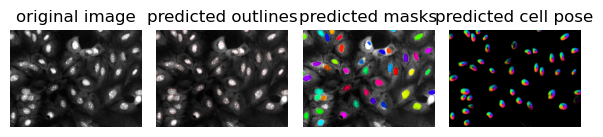

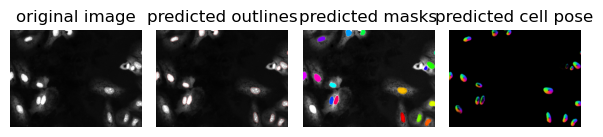

{'nuclei': [PosixPath('/Users/romankoval/data/cyto/nuclei/B2_01_1_7_GFP_001_cp_nuclei_mask.tif'),
  PosixPath('/Users/romankoval/data/cyto/nuclei/B2_01_1_8_GFP_001_cp_nuclei_mask.tif')]}

In [ ]:
from pathlib import Path

# For nuclei
cell_segment_simple(
    img_dir=Path("/Users/romankoval/data/flat_dark_apply"),
    out_root=Path("/Users/romankoval/data/cyto"),
    model_types=["nuclei"],
    channels=(0, 0),
    diameter_px=30,
    normalize01=False,
    gpu=True,
    preview_n=3,
    save_previews=False
)


2025-10-15 09:09:20,507 [INFO] WRITING LOG OUTPUT TO /Users/romankoval/.cellpose/run.log
2025-10-15 09:09:20,509 [INFO] 
cellpose version: 	3.1.1.2 
platform:       	darwin 
python version: 	3.13.7 
torch version:  	2.8.0
[INFO] Running Cellpose model: cyto2
2025-10-15 09:09:20,515 [INFO] >> cyto2 << model set to be used
2025-10-15 09:09:20,516 [INFO] ** TORCH MPS version installed and working. **
2025-10-15 09:09:20,517 [INFO] >>>> using GPU (MPS)
2025-10-15 09:09:20,642 [INFO] >>>> loading model /Users/romankoval/.cellpose/models/cyto2torch_0
2025-10-15 09:09:20,733 [INFO] >>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
2025-10-15 09:09:25,187 [INFO] 100%|##########| 2/2 [00:04<00:00,  2.23s/it]


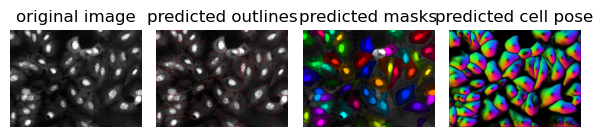

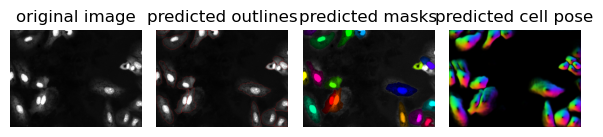

{'cyto2': [PosixPath('/Users/romankoval/data/cyto/cyto2/B2_01_1_7_GFP_001_cp_cyto2_mask.tif'),
  PosixPath('/Users/romankoval/data/cyto/cyto2/B2_01_1_8_GFP_001_cp_cyto2_mask.tif')]}

In [28]:
# For cyto2
cell_segment_simple(
    img_dir=Path("/Users/romankoval/data/flat_dark_apply"),
    out_root=Path("/Users/romankoval/data/cyto"),
    model_types=["cyto2"],
    channels=(0, 0),
    diameter_px=90,
    normalize01=False,
    gpu=True,
    preview_n=3,
    save_previews=True
)


In [23]:
import my_def
from my_def import cell_segment

In [24]:
cell_segment(
    img_dir=Path("/Users/romankoval/data/flat_dark_apply"),
    out_root=Path("/Users/romankoval/data/cyto"),
    model_types=["cyto2"],
    channels=(0, 0),
    diameter_px=90,
    normalize01=False,
    gpu=True,
    preview_n=3,
    save_previews=True
)

TypeError: cell_segment() got an unexpected keyword argument 'diameter_px'. Did you mean 'diameters'?

In [25]:
from skimage.measure import regionprops_table
from skimage.morphology import disk, binary_dilation
from pathlib import Path
import re
from typing import Dict, List, Tuple
import numpy as np
import pandas as pd
import tifffile as tiff
from skimage.morphology import disk, binary_dilation

2025-10-15 09:05:15,479 [INFO] NumExpr defaulting to 10 threads.


[OK] B2_01_1_7_GFP_001: kept 40 / 52 cells


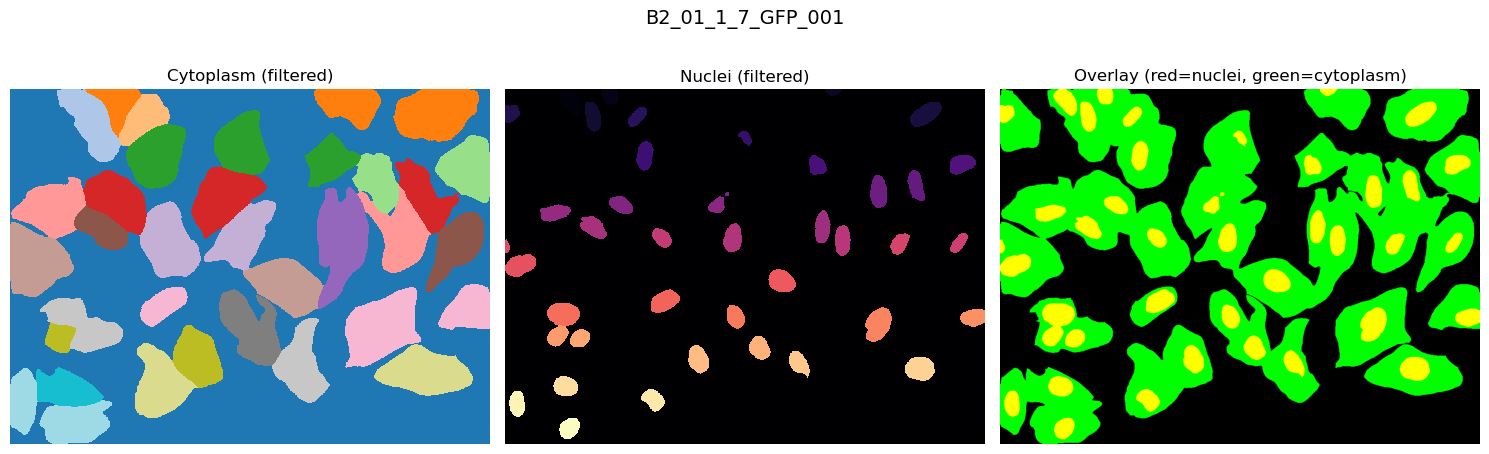

[OK] B2_01_1_8_GFP_001: kept 14 / 18 cells


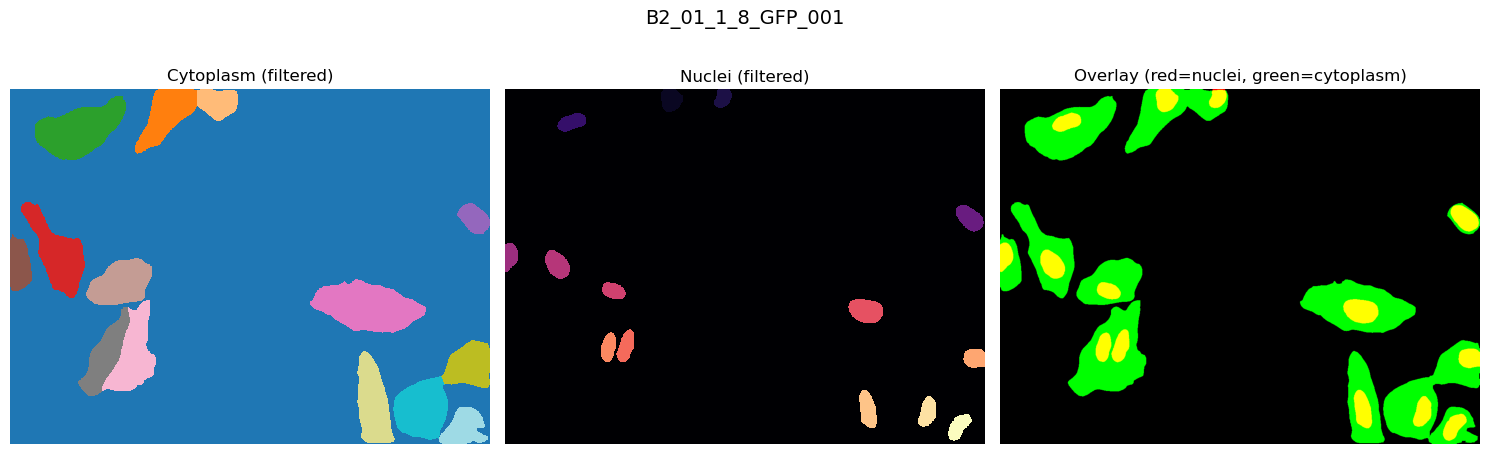

[INFO] Saved summary → /Users/romankoval/data/cyto/filtered/_filter_summary.csv
                 key                                         input_cyto  \
0  B2_01_1_7_GFP_001  /Users/romankoval/data/cyto/cyto2/B2_01_1_7_GF...   
1  B2_01_1_8_GFP_001  /Users/romankoval/data/cyto/cyto2/B2_01_1_8_GF...   

                                           input_nuc  n_cells_before  \
0  /Users/romankoval/data/cyto/nuclei/B2_01_1_7_G...              52   
1  /Users/romankoval/data/cyto/nuclei/B2_01_1_8_G...              18   

   n_nuclei_before  n_common_cells  
0               43              40  
1               16              14  


In [ ]:
from pathlib import Path
from typing import Dict, List, Set, Tuple
import numpy as np
import pandas as pd
import tifffile as tiff
import matplotlib.pyplot as plt

# ======================================================
# 1️⃣ Single-image filtering function
# ======================================================
def filter_common_labels(
    lbl_cyto: np.ndarray,
    lbl_nuc: np.ndarray,
    min_overlap_px: int = 1
) -> Tuple[np.ndarray, np.ndarray, Set[int]]:
    """
    Keep only labels that exist in both cytoplasm (cyto2) and nuclei masks.
    Returns filtered masks and the set of shared cell labels.
    """
    assert lbl_cyto.ndim == 2 and lbl_nuc.ndim == 2, "Only 2D masks supported"
    lbl_cyto = lbl_cyto.astype(np.int32, copy=False)
    lbl_nuc  = lbl_nuc.astype(np.int32,  copy=False)

    nuc_labels = np.unique(lbl_nuc)
    nuc_labels = nuc_labels[nuc_labels != 0]

    nuc_to_cell = {}
    for nl in nuc_labels:
        m = (lbl_nuc == nl)
        cells_all, counts_all = np.unique(lbl_cyto[m], return_counts=True)
        mask_fg = (cells_all != 0)
        cells = cells_all[mask_fg]
        counts = counts_all[mask_fg]

        if cells.size == 0:
            nuc_to_cell[int(nl)] = 0
            continue

        best_idx = int(np.argmax(counts))
        if int(counts[best_idx]) >= int(min_overlap_px):
            nuc_to_cell[int(nl)] = int(cells[best_idx])
        else:
            nuc_to_cell[int(nl)] = 0

    common_cells: Set[int] = {cl for cl in nuc_to_cell.values() if cl != 0}

    lbl_cyto_f = np.where(np.isin(lbl_cyto, list(common_cells)), lbl_cyto, 0)

    lbl_nuc_f = np.zeros_like(lbl_nuc, np.int32)
    for nl, cl in nuc_to_cell.items():
        if cl != 0:
            lbl_nuc_f[lbl_nuc == nl] = nl

    return lbl_cyto_f, lbl_nuc_f, common_cells


# ======================================================
# 2️⃣ Plotting helper
# ======================================================
def plot_filtered_labels(lbl_cyto, lbl_nuc, title=None):
    """Visualize filtered cytoplasm, nuclei, and overlay."""
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(lbl_cyto, cmap="tab20", interpolation="none")
    axes[0].set_title("Cytoplasm (filtered)")
    
    axes[1].imshow(lbl_nuc, cmap="magma", interpolation="none")
    axes[1].set_title("Nuclei (filtered)")
    
    overlay = np.zeros((*lbl_cyto.shape, 3), dtype=float)
    overlay[..., 1] = (lbl_cyto > 0)  # green
    overlay[..., 0] = (lbl_nuc > 0)   # red
    axes[2].imshow(overlay)
    axes[2].set_title("Overlay (red=nuclei, green=cytoplasm)")
    
    for ax in axes:
        ax.axis("off")
    if title:
        fig.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()


# ======================================================
# 3️⃣ Batch driver
# ======================================================
def base_key(p: Path) -> str:
    """Extract common base name for pairing cyto2 and nuclei masks."""
    for token in ("_cp_cyto2_mask", "_cp_nuclei_mask"):
        if p.stem.endswith(token):
            return p.stem[: -len(token)]
    return p.stem

def batch_filter_common_labels(
    cyto_dir: Path,
    nuclei_dir: Path,
    out_dir: Path,
    *,
    cyto_tag: str = "cyto2",
    nuclei_tag: str = "nuclei",
    min_overlap_px: int = 1,
    plot_results: bool = True
) -> pd.DataFrame:
    """
    Filter all images in two folders (cytoplasm & nuclei).
    Saves *_cyto_filtered.tif and *_nuc_filtered.tif in out_dir,
    and returns a summary DataFrame.
    """
    cyto_dir, nuclei_dir, out_dir = Path(cyto_dir), Path(nuclei_dir), Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)

    cyto_map = {base_key(p): p for p in cyto_dir.glob("*.tif") if cyto_tag.lower() in p.name.lower()}
    nuc_map  = {base_key(p): p for p in nuclei_dir.glob("*.tif") if nuclei_tag.lower() in p.name.lower()}
    keys = sorted(set(cyto_map) & set(nuc_map))
    if not keys:
        raise FileNotFoundError("No matching image pairs found.")

    rows = []
    for k in keys:
        p_cell = cyto_map[k]
        p_nuc  = nuc_map[k]
        lbl_c = tiff.imread(str(p_cell))
        lbl_n = tiff.imread(str(p_nuc))

        lbl_c_f, lbl_n_f, common = filter_common_labels(lbl_c, lbl_n, min_overlap_px=min_overlap_px)

        out_c = out_dir / f"{k}_cyto_filtered.tif"
        out_n = out_dir / f"{k}_nuc_filtered.tif"
        tiff.imwrite(str(out_c), lbl_c_f.astype(np.uint16), photometric="minisblack")
        tiff.imwrite(str(out_n), lbl_n_f.astype(np.uint16), photometric="minisblack")

        rows.append({
            "key": k,
            "input_cyto": str(p_cell),
            "input_nuc": str(p_nuc),
            "n_cells_before": int(np.unique(lbl_c).size - 1),
            "n_nuclei_before": int(np.unique(lbl_n).size - 1),
            "n_common_cells": len(common)
        })

        print(f"[OK] {k}: kept {len(common)} / {np.unique(lbl_c).size - 1} cells")

        if plot_results:
            plot_filtered_labels(lbl_c_f, lbl_n_f, title=k)

    df = pd.DataFrame(rows)
    df.to_csv(out_dir / "_filter_summary.csv", index=False)
    print(f"[INFO] Saved summary → {out_dir/'_filter_summary.csv'}")
    return df




[OK] B2_01_1_7_GFP_001: kept 40 / 52 cells


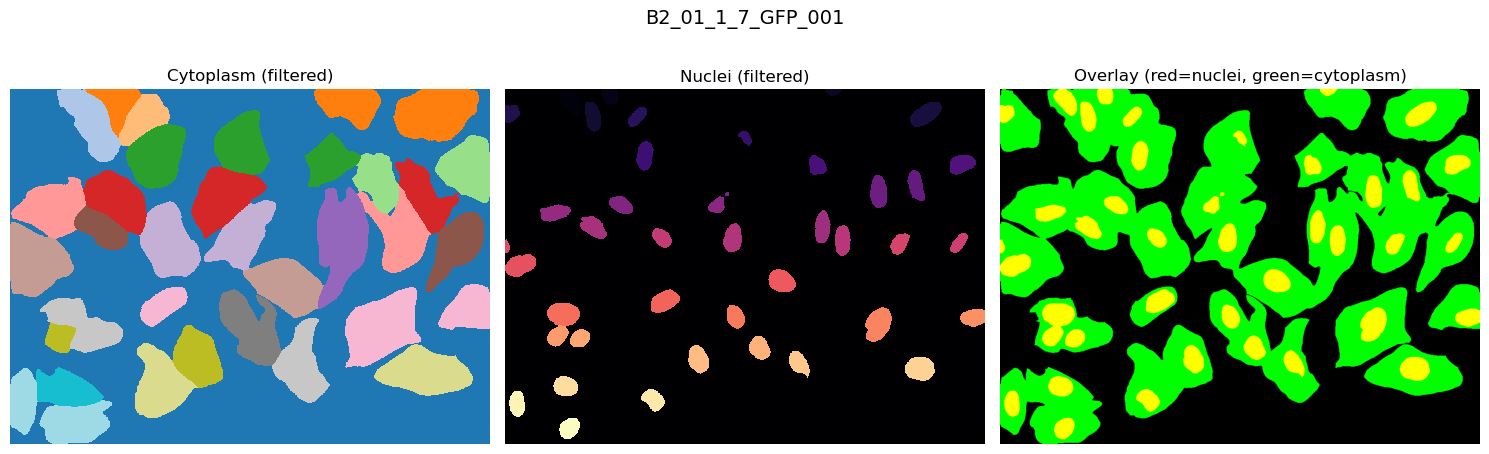

[OK] B2_01_1_8_GFP_001: kept 14 / 18 cells


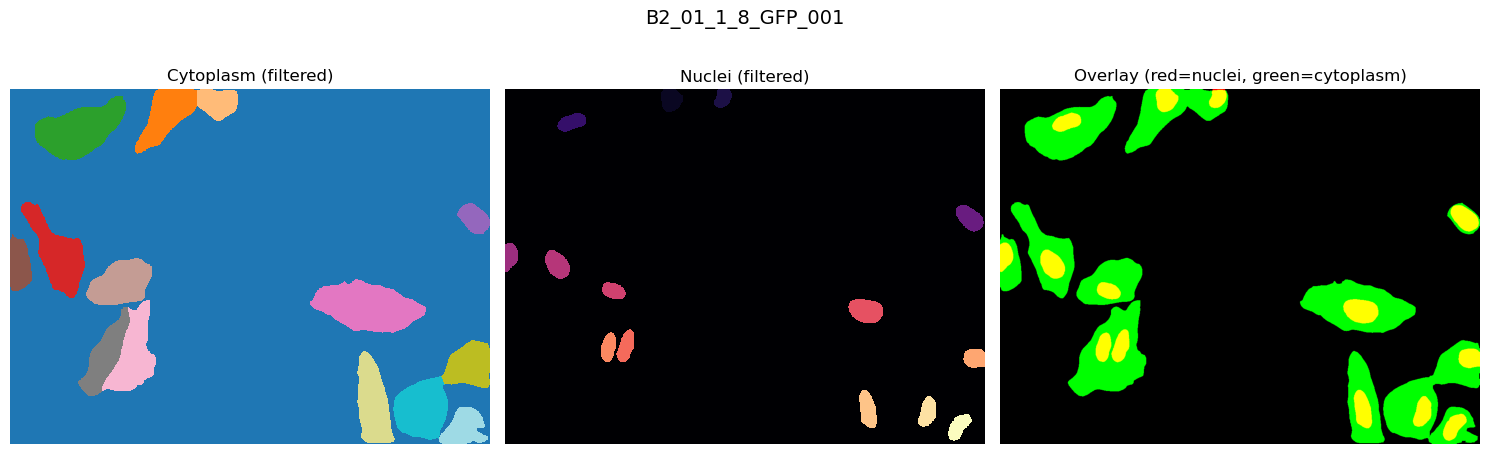

[INFO] Saved summary → /Users/romankoval/data/cyto/filtered/_filter_summary.csv
                 key                                         input_cyto  \
0  B2_01_1_7_GFP_001  /Users/romankoval/data/cyto/cyto2/B2_01_1_7_GF...   
1  B2_01_1_8_GFP_001  /Users/romankoval/data/cyto/cyto2/B2_01_1_8_GF...   

                                           input_nuc  n_cells_before  \
0  /Users/romankoval/data/cyto/nuclei/B2_01_1_7_G...              52   
1  /Users/romankoval/data/cyto/nuclei/B2_01_1_8_G...              18   

   n_nuclei_before  n_common_cells  
0               43              40  
1               16              14  


In [37]:
# ======================================================
# 4️⃣ Example run
# ======================================================
if __name__ == "__main__":
    df_summary = batch_filter_common_labels(
        cyto_dir=Path("/Users/romankoval/data/cyto/cyto2"),
        nuclei_dir=Path("/Users/romankoval/data/cyto/nuclei"),
        out_dir=Path("/Users/romankoval/data/cyto/filtered"),
        cyto_tag="cyto2",
        nuclei_tag="nuclei",
        min_overlap_px=3,
        plot_results=True
    )

    print(df_summary.head())



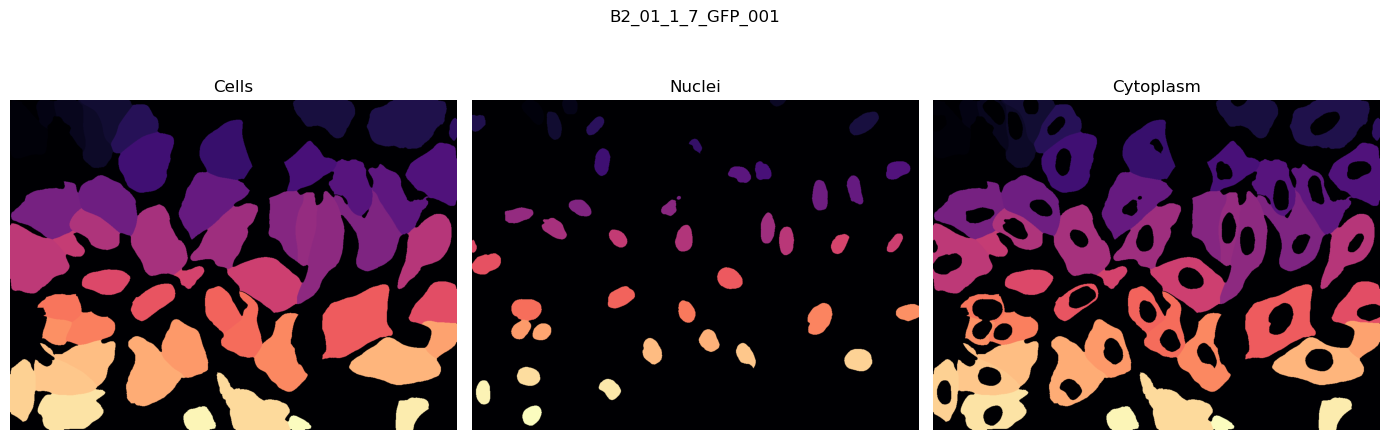

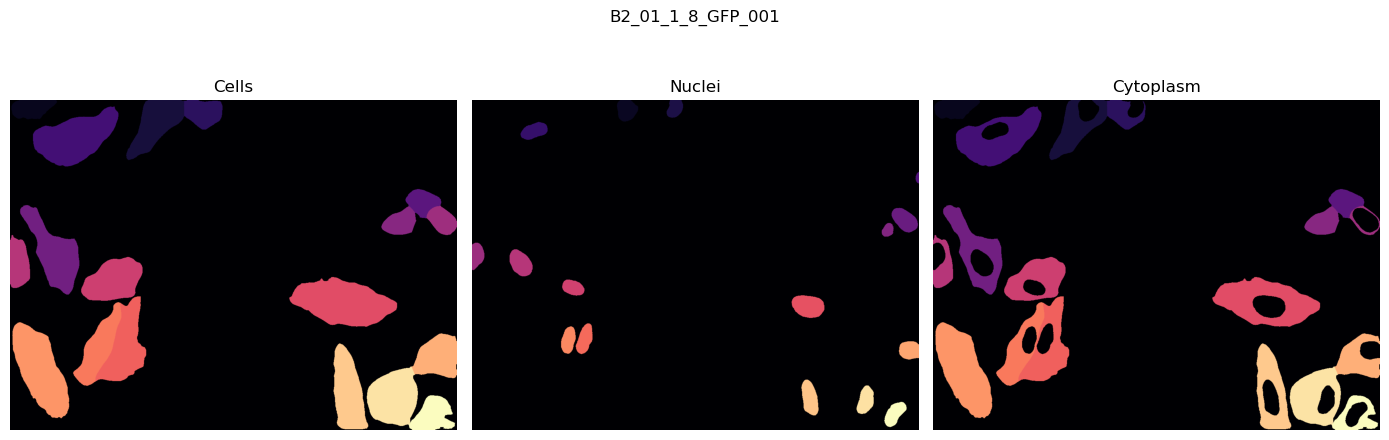

In [ ]:
from pathlib import Path
import tifffile as tiff
import matplotlib.pyplot as plt
import numpy as np

cyto_dir = Path("/Users/romankoval/data/cyto/cyto2")
nuc_dir  = Path("/Users/romankoval/data/cyto/nuclei")
out_dir  = Path("/Users/romankoval/data/cyto/cytoplasm_out")
out_dir.mkdir(parents=True, exist_ok=True)

def base(stem):
    for token in ("_cp_cyto2_mask", "_cp_nuclei_mask"):
        if stem.endswith(token): return stem[: -len(token)]
    return stem

cyto_map = {base(p.stem): p for p in cyto_dir.glob("*.tif")}
nuc_map  = {base(p.stem): p for p in nuc_dir.glob("*.tif")}
keys = sorted(set(cyto_map) & set(nuc_map))

for k in keys:
    lbl_cell = tiff.imread(str(cyto_map[k]))
    lbl_nuc  = tiff.imread(str(nuc_map[k]))
    cyto = lbl_cell.copy()
    cyto[(lbl_cell > 0) & (lbl_nuc > 0)] = 0

    out_fp = out_dir / f"{k}_cytoplasm.tif"
    tiff.imwrite(str(out_fp), cyto.astype(np.uint16), photometric="minisblack")

    # Plot preview (optional)
    fig, axes = plt.subplots(1, 3, figsize=(14, 5))
    axes[0].imshow(lbl_cell, cmap="magma"); axes[0].set_title("Cells")
    axes[1].imshow(lbl_nuc, cmap="magma");  axes[1].set_title("Nuclei")
    axes[2].imshow(cyto, cmap="magma");     axes[2].set_title("Cytoplasm")
    for ax in axes: ax.axis("off")
    plt.suptitle(k)
    plt.tight_layout()
    plt.show()



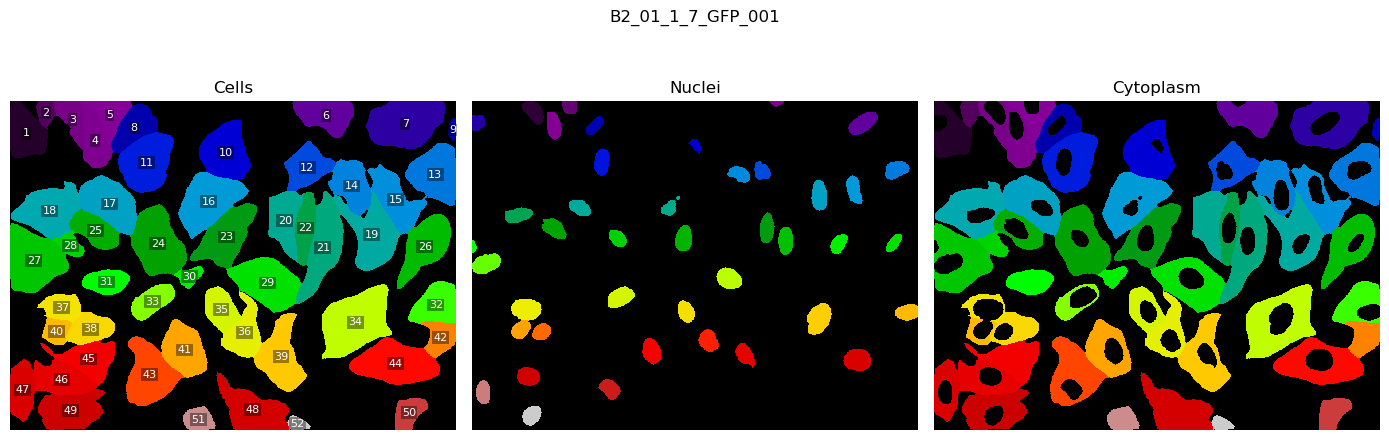

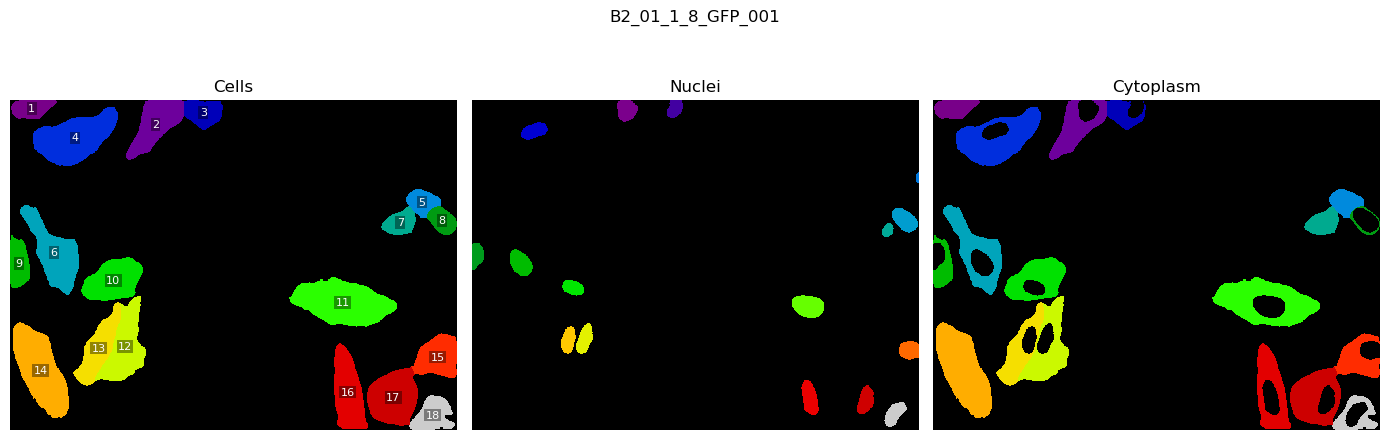

In [39]:
from pathlib import Path
import tifffile as tiff
import matplotlib.pyplot as plt
import numpy as np
from skimage.measure import regionprops

cyto_dir = Path("/Users/romankoval/data/cyto/cyto2")
nuc_dir  = Path("/Users/romankoval/data/cyto/nuclei")
out_dir  = Path("/Users/romankoval/data/cyto/cytoplasm_out")
out_dir.mkdir(parents=True, exist_ok=True)

def base(stem):
    for token in ("_cp_cyto2_mask", "_cp_nuclei_mask"):
        if stem.endswith(token): return stem[: -len(token)]
    return stem

cyto_map = {base(p.stem): p for p in cyto_dir.glob("*.tif")}
nuc_map  = {base(p.stem): p for p in nuc_dir.glob("*.tif")}
keys = sorted(set(cyto_map) & set(nuc_map))

for k in keys:
    lbl_cell = tiff.imread(str(cyto_map[k]))
    lbl_nuc  = tiff.imread(str(nuc_map[k]))
    cyto = lbl_cell.copy()
    cyto[(lbl_cell > 0) & (lbl_nuc > 0)] = 0

    out_fp = out_dir / f"{k}_cytoplasm.tif"
    tiff.imwrite(str(out_fp), cyto.astype(np.uint16), photometric="minisblack")

    # ---------- Plot ----------
    fig, axes = plt.subplots(1, 3, figsize=(14, 5))
    for ax, img, title in zip(
        axes,
        [lbl_cell, lbl_nuc, cyto],
        ["Cells", "Nuclei", "Cytoplasm"]
    ):
        ax.imshow(img, cmap="nipy_spectral", interpolation="none")
        ax.set_title(title)
        ax.axis("off")

        # Label each cell region with its numeric ID (centroid)
        if title == "Cells":
            props = regionprops(lbl_cell)
            for p in props:
                y, x = p.centroid
                ax.text(
                    x, y, str(p.label),
                    color="white", fontsize=8, ha="center", va="center",
                    bbox=dict(facecolor="black", edgecolor="none", pad=1, alpha=0.4)
                )

    plt.suptitle(k)
    plt.tight_layout()
    plt.show()


In [48]:
import numpy as np
import pandas as pd
from typing import Optional
from skimage.measure import regionprops_table
from scipy.ndimage import label as ndi_label

def nuclei_morphometry_from_labels(
    labels: np.ndarray,
    *,
    pixel_size_um: Optional[float] = None,
    min_area_px: int = 0,
    add_feret: bool = True
) -> pd.DataFrame:
    """
    Compute morphometric features for a nucleus label image (2D).
    Returns one row per nucleus (label > 0).
    """
    assert labels.ndim == 2, f"Expected 2D labels, got {labels.shape}"
    labels = labels.astype(np.int32, copy=False)

    # Optional debris filter → relabel to keep contiguous IDs
    if min_area_px > 0:
        keep = np.zeros_like(labels, bool)
        for lab in np.unique(labels):
            if lab == 0: 
                continue
            if np.count_nonzero(labels == lab) >= min_area_px:
                keep |= (labels == lab)
        labels, _ = ndi_label(keep)

    props = [
        "label","area","perimeter",
        "equivalent_diameter",
        "major_axis_length","minor_axis_length",
        "eccentricity","solidity","extent","convex_area"
    ]
    if add_feret:
        try:
            _ = regionprops_table(labels, properties=("feret_diameter_max",))
            props.append("feret_diameter_max")
        except Exception:
            pass

    tbl = regionprops_table(labels, properties=tuple(props))
    df = pd.DataFrame(tbl)
    if df.empty:
        return df

    # Derived metrics
    df["circularity"] = (4*np.pi*df["area"]) / np.maximum(df["perimeter"], 1e-6)**2

    # Unit conversions
    if pixel_size_um is not None:
        px = float(pixel_size_um)
        df["area_um2"] = df["area"] * (px**2)
        df["perimeter_um"] = df["perimeter"] * px
        df["major_axis_length_um"] = df["major_axis_length"] * px
        df["minor_axis_length_um"] = df["minor_axis_length"] * px
        if "feret_diameter_max" in df:
            df["feret_diameter_max_um"] = df["feret_diameter_max"] * px

    return df


In [49]:
from pathlib import Path

df_nuc = batch_nuclei_morphometry(
    nuclei_dir=Path("/Users/romankoval/data/cyto/nuclei"),
    out_csv=Path("/Users/romankoval/data/cyto/metrics_out/nuclei_morph.csv"),
    min_area_px=20,
    pixel_size_um=0.325,
    nuclei_tag="nuclei"
)

df_nuc.head()



[INFO] Saved 58 nuclei rows → /Users/romankoval/data/cyto/metrics_out/nuclei_morph.csv


,image,label,area,perimeter,equivalent_diameter,major_axis_length,minor_axis_length,eccentricity,solidity,extent,convex_area,feret_diameter_max,circularity,area_um2,perimeter_um,major_axis_length_um,minor_axis_length_um,feret_diameter_max_um
0,B2_01_1_7_GFP_001_cp_nuclei_mask,1,2706.0,205.965512,58.697412,78.017515,44.964081,0.817215,0.977248,0.652363,2769.0,77.524190,0.801583,285.821250,66.938791,25.355692,14.613326,25.195362
1,B2_01_1_7_GFP_001_cp_nuclei_mask,2,1443.0,141.597980,42.863559,45.487588,41.170797,0.425200,0.988356,0.880952,1460.0,49.203658,0.904403,152.416875,46.019343,14.783466,13.380509,15.991189
2,B2_01_1_7_GFP_001_cp_nuclei_mask,3,561.0,105.012193,26.726155,42.212695,18.372896,0.900312,0.980769,0.708333,572.0,44.283180,0.639283,59.255625,34.128963,13.719126,5.971191,14.392033
3,B2_01_1_7_GFP_001_cp_nuclei_mask,4,2483.0,202.610173,56.226807,80.390535,39.607465,0.870206,0.979101,0.786506,2536.0,80.081209,0.760088,262.266875,65.848306,26.126924,12.872426,26.026393
4,B2_01_1_7_GFP_001_cp_nuclei_mask,5,3356.0,233.764502,65.368126,91.975766,46.543921,0.862507,0.978996,0.637417,3428.0,91.268834,0.771747,354.477500,75.973463,29.892124,15.126774,29.662371


In [50]:
import numpy as np
import pandas as pd
from typing import Optional
from skimage.measure import regionprops_table
from scipy.ndimage import label as ndi_label

def cytoplasm_morphometry_from_labels(
    labels: np.ndarray,
    *,
    pixel_size_um: Optional[float] = None,
    min_area_px: int = 0,
    add_feret: bool = True
) -> pd.DataFrame:
    """
    Compute morphometric features for a cytoplasm label image (2D).
    Returns one row per cell/cytoplasm (label > 0).
    """
    assert labels.ndim == 2, f"Expected 2D labels, got {labels.shape}"
    labels = labels.astype(np.int32, copy=False)

    # Optional debris filter → relabel to keep contiguous IDs
    if min_area_px > 0:
        keep = np.zeros_like(labels, bool)
        for lab in np.unique(labels):
            if lab == 0: 
                continue
            if np.count_nonzero(labels == lab) >= min_area_px:
                keep |= (labels == lab)
        labels, _ = ndi_label(keep)

    props = [
        "label","area","perimeter",
        "equivalent_diameter",
        "major_axis_length","minor_axis_length",
        "eccentricity","solidity","extent","convex_area"
    ]
    if add_feret:
        try:
            _ = regionprops_table(labels, properties=("feret_diameter_max",))
            props.append("feret_diameter_max")
        except Exception:
            pass

    tbl = regionprops_table(labels, properties=tuple(props))
    df = pd.DataFrame(tbl)
    if df.empty:
        return df

    # Derived metrics
    df["circularity"] = (4*np.pi*df["area"]) / np.maximum(df["perimeter"], 1e-6)**2

    # Unit conversions
    if pixel_size_um is not None:
        px = float(pixel_size_um)
        df["area_um2"] = df["area"] * (px**2)
        df["perimeter_um"] = df["perimeter"] * px
        df["major_axis_length_um"] = df["major_axis_length"] * px
        df["minor_axis_length_um"] = df["minor_axis_length"] * px
        if "feret_diameter_max" in df:
            df["feret_diameter_max_um"] = df["feret_diameter_max"] * px

    return df


In [51]:
from pathlib import Path
import tifffile as tiff

def batch_cytoplasm_morphometry(
    cyto_dir: Path,
    out_csv: Path,
    *,
    min_area_px: int = 0,
    pixel_size_um: Optional[float] = None,
    cyto_tag: Optional[str] = "cytoplasm"   # set to None to include all *.tif
) -> pd.DataFrame:
    """
    Find cytoplasm masks (*.tif) in cyto_dir, compute morphometrics, save CSV.
    If cyto_tag is set, only files containing that token in the name are used.
    """
    cyto_dir = Path(cyto_dir)

    # File list
    if cyto_tag:
        files = sorted(p for p in cyto_dir.rglob("*.tif") if cyto_tag.lower() in p.name.lower())
    else:
        files = sorted(cyto_dir.rglob("*.tif"))

    if not files:
        raise FileNotFoundError(f"No cytoplasm masks found in {cyto_dir}")

    rows = []
    for fp in files:
        lbl = tiff.imread(str(fp))
        if lbl.ndim != 2:
            print(f"[WARN] skip non-2D: {fp.name} ({lbl.shape})")
            continue
        df = cytoplasm_morphometry_from_labels(
            lbl,
            pixel_size_um=pixel_size_um,
            min_area_px=min_area_px,
            add_feret=True
        )
        if df.empty:
            continue
        df.insert(0, "image", fp.stem)
        rows.append(df)

    out = pd.concat(rows, ignore_index=True) if rows else pd.DataFrame()
    if not out.empty:
        out_csv = Path(out_csv)
        out_csv.parent.mkdir(parents=True, exist_ok=True)
        out.to_csv(out_csv, index=False)
        print(f"[INFO] Saved {len(out)} cytoplasm rows → {out_csv}")
    else:
        print("[INFO] No cytoplasm objects found after filtering.")
    return out


In [52]:
from pathlib import Path

df_cyto = batch_cytoplasm_morphometry(
    cyto_dir=Path("/Users/romankoval/data/cyto/cytoplasm_out"),          # where *_cytoplasm.tif were saved
    out_csv=Path("/Users/romankoval/data/cyto/metrics_out/cytoplasm_morph.csv"),
    min_area_px=30,                 # debris filter
    pixel_size_um=0.325,            # add µm/µm² columns
    cyto_tag="cytoplasm"            # or None if names don't contain this token
)

df_cyto.head()


[INFO] Saved 29 cytoplasm rows → /Users/romankoval/data/cyto/metrics_out/cytoplasm_morph.csv


,image,label,area,perimeter,equivalent_diameter,major_axis_length,minor_axis_length,eccentricity,solidity,extent,convex_area,feret_diameter_max,circularity,area_um2,perimeter_um,major_axis_length_um,minor_axis_length_um,feret_diameter_max_um
0,B2_01_1_7_GFP_001_cytoplasm,1,55078.0,2545.979977,264.815951,528.556574,222.578301,0.907011,0.615397,0.482945,89500.0,476.471405,0.106777,5817.613750,827.443493,171.780886,72.337948,154.853207
1,B2_01_1_7_GFP_001_cytoplasm,2,11738.0,496.274170,122.250913,175.962074,96.383380,0.836641,0.897058,0.657591,13085.0,173.173324,0.598909,1239.826250,161.289105,57.187674,31.324598,56.281330
2,B2_01_1_7_GFP_001_cytoplasm,3,19643.0,857.938167,158.146275,236.903555,143.411480,0.795953,0.832931,0.669359,23583.0,226.850171,0.335356,2074.791875,278.829904,76.993655,46.608731,73.726306
3,B2_01_1_7_GFP_001_cytoplasm,4,1075.0,146.669048,36.996385,63.170836,22.227127,0.936054,0.971093,0.775613,1107.0,63.285069,0.627974,113.546875,47.667440,20.530522,7.223816,20.567648
4,B2_01_1_7_GFP_001_cytoplasm,5,176248.0,7727.750247,473.715023,851.182560,455.167986,0.845012,0.557597,0.437234,316085.0,787.078141,0.037088,18616.195000,2511.518830,276.634332,147.929596,255.800396


In [53]:
from pathlib import Path
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt
from skimage.measure import regionprops
from skimage.segmentation import find_boundaries

def plot_cyto_nuc_pair(
    cyto_path: Path,
    nuc_path: Path,
    *,
    raw_path: Path | None = None,   # optional grayscale image for context
    title: str | None = None,
    save_png: Path | None = None,
    show_ids: bool = True
):
    cyto = tiff.imread(str(cyto_path))
    nuc  = tiff.imread(str(nuc_path))
    assert cyto.ndim == 2 and nuc.ndim == 2, "Only 2D masks supported"

    # Build overlay
    if raw_path is not None:
        raw = tiff.imread(str(raw_path))
        # scale raw for display if integral type
        if np.issubdtype(raw.dtype, np.integer):
            raw_disp = raw.astype(np.float32)
            m = raw_disp.max()
            if m > 0: raw_disp /= m
        else:
            raw_disp = raw
    else:
        raw_disp = np.zeros_like(cyto, dtype=float)

    # Nuclei + cytoplasm boundaries for crisp edges
    b_cyto = find_boundaries(cyto, mode="outer")
    b_nuc  = find_boundaries(nuc,  mode="outer")

    fig, axes = plt.subplots(1, 3 if raw_path is None else 4, figsize=(16, 5))

    # Panel 1 — Cytoplasm labels
    ax = axes[0]
    ax.imshow(cyto, cmap="nipy_spectral", interpolation="none")
    ax.set_title("Cytoplasm (labels)")
    ax.axis("off")
    if show_ids:
        for p in regionprops(cyto):
            y, x = p.centroid
            ax.text(x, y, str(p.label),
                    color="white", fontsize=8, ha="center", va="center",
                    bbox=dict(facecolor="black", edgecolor="none", pad=1, alpha=0.4))

    # Panel 2 — Nuclei labels
    ax = axes[1]
    ax.imshow(nuc, cmap="magma", interpolation="none")
    ax.set_title("Nuclei (labels)")
    ax.axis("off")
    if show_ids:
        for p in regionprops(nuc):
            y, x = p.centroid
            ax.text(x, y, str(p.label),
                    color="white", fontsize=8, ha="center", va="center",
                    bbox=dict(facecolor="black", edgecolor="none", pad=1, alpha=0.4))

    # Panel 3 — Overlay (green=cyto, red=nuc)
    ax = axes[2]
    overlay = np.zeros((*cyto.shape, 3), dtype=float)
    overlay[..., 1] = (cyto > 0)  # green
    overlay[..., 0] = (nuc  > 0)  # red
    ax.imshow(overlay)
    ax.set_title("Overlay (red=nuc, green=cyto)")
    ax.axis("off")

    # Optional Panel 4 — Overlay on raw
    if raw_path is not None:
        ax = axes[3]
        ax.imshow(raw_disp, cmap="gray")
        ax.contour(b_cyto, colors="lime", linewidths=0.8)
        ax.contour(b_nuc,  colors="r",    linewidths=0.8)
        ax.set_title("Raw + boundaries")
        ax.axis("off")

    if title:
        fig.suptitle(title, fontsize=14)
    plt.tight_layout()

    if save_png is not None:
        Path(save_png).parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(save_png, dpi=150, bbox_inches="tight")
    plt.show()


In [54]:
plot_cyto_nuc_pair(
    cyto_path=Path("/Users/romankoval/data/cyto/filtered/B2_01_1_3_GFP_001_cyto_filtered.tif"),
    nuc_path =Path("/Users/romankoval/data/cyto/filtered/B2_01_1_3_GFP_001_nuc_filtered.tif"),
    raw_path=Path("/Users/romankoval/data/raw/B2_01_1_3_GFP_001.tif"),  # optional
    title="B2_01_1_3_GFP_001",
    save_png=Path("/Users/romankoval/data/cyto/plots/B2_01_1_3_GFP_001_overlay.png"),
    show_ids=True
)


FileNotFoundError: [Errno 2] No such file or directory: '/Users/romankoval/data/cyto/filtered/B2_01_1_3_GFP_001_cyto_filtered.tif'

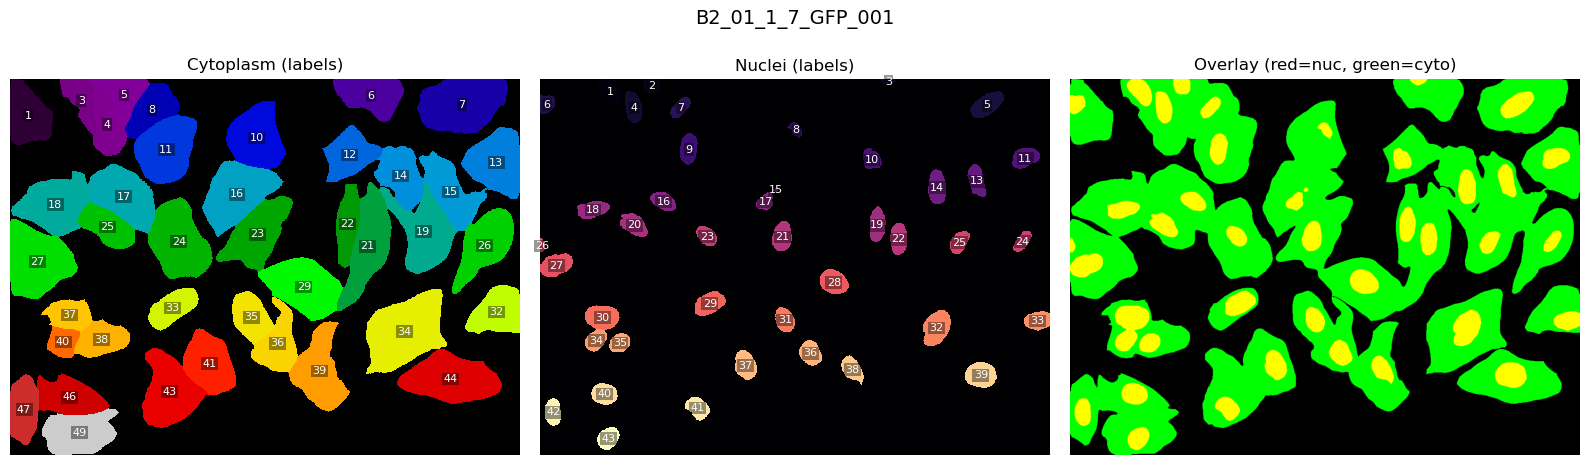

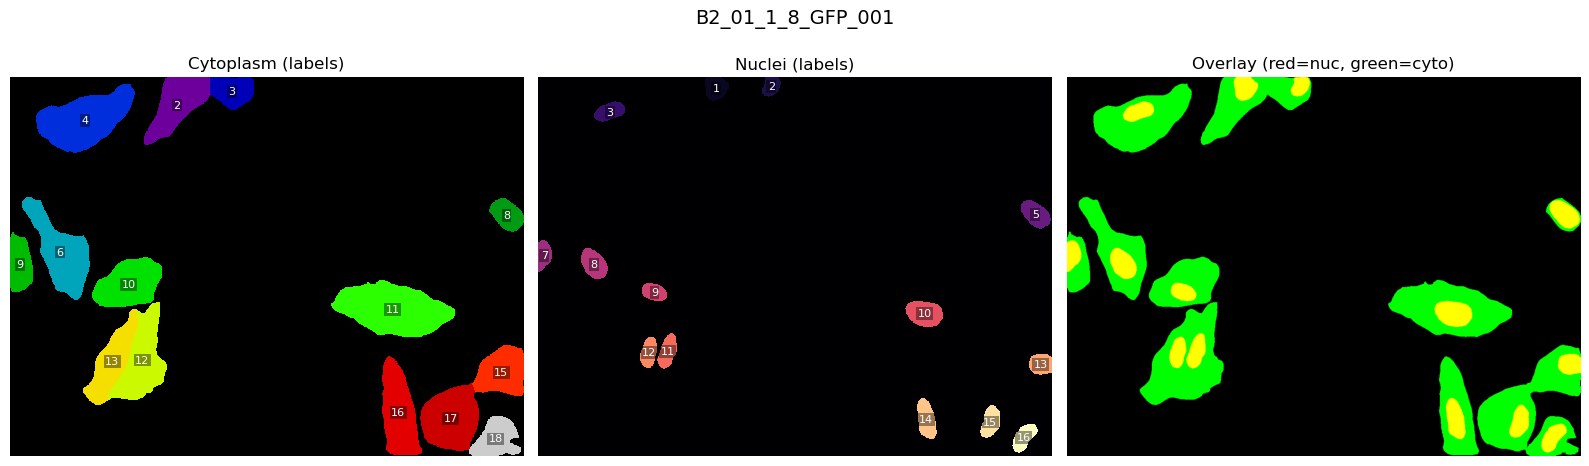

In [56]:
from pathlib import Path

plot_cyto_nuc_pair(
    cyto_path=Path("/Users/romankoval/data/cyto/filtered/B2_01_1_7_GFP_001_cyto_filtered.tif"),
    nuc_path =Path("/Users/romankoval/data/cyto/filtered/B2_01_1_7_GFP_001_nuc_filtered.tif"),
    title="B2_01_1_7_GFP_001",
    show_ids=True
)

plot_cyto_nuc_pair(
    cyto_path=Path("/Users/romankoval/data/cyto/filtered/B2_01_1_8_GFP_001_cyto_filtered.tif"),
    nuc_path =Path("/Users/romankoval/data/cyto/filtered/B2_01_1_8_GFP_001_nuc_filtered.tif"),
    title="B2_01_1_8_GFP_001",
    show_ids=True
)



In [58]:
!pip install seaborn

/var/folders/7r/mv_z8mtj4xvfshrcj_2fcv_m0000gn/T/ipykernel_1523/3084325465.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Object Type")


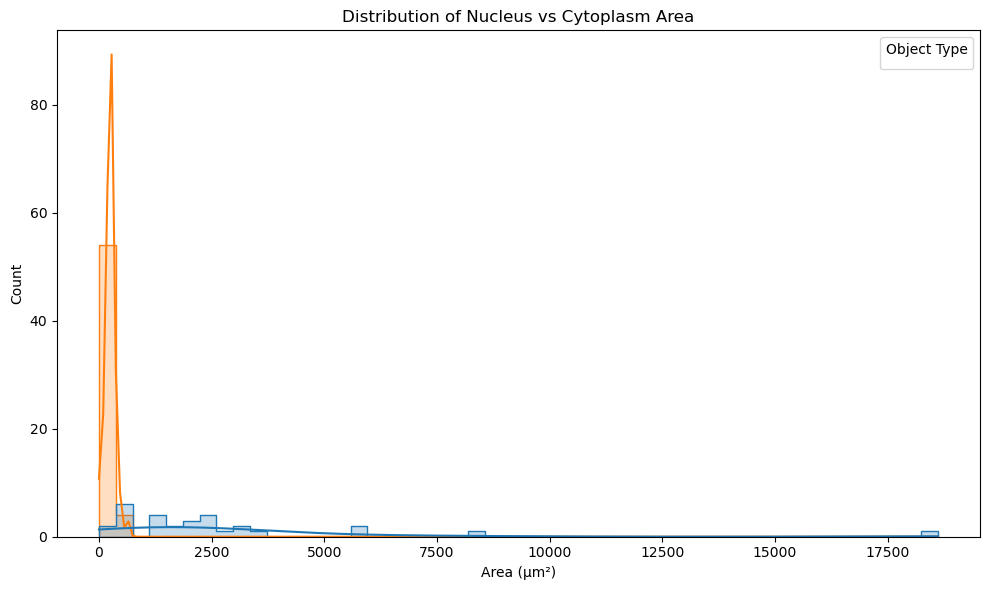

/var/folders/7r/mv_z8mtj4xvfshrcj_2fcv_m0000gn/T/ipykernel_1523/3084325465.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_all, x="Type", y="area_um2", inner="quartile", palette="Set2")


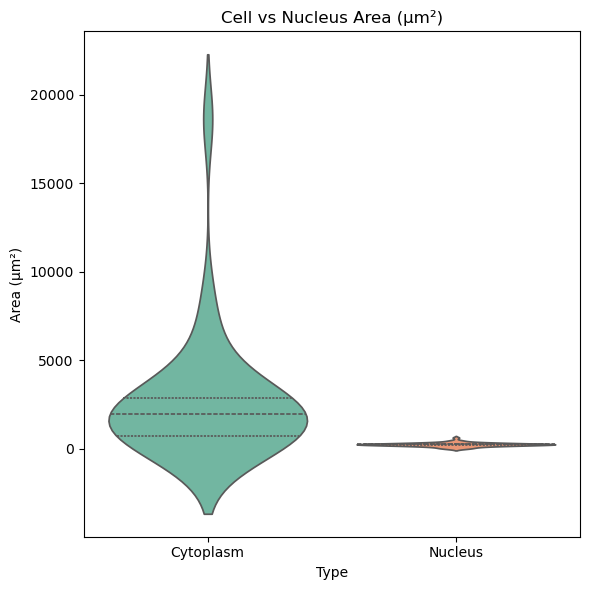

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Paths to your morphometry CSVs
cyto_csv = Path("/Users/romankoval/data/cyto/metrics_out/cytoplasm_morph.csv")
nuc_csv  = Path("/Users/romankoval/data/cyto/metrics_out/nuclei_morph.csv")

# Load tables
df_cyto = pd.read_csv(cyto_csv)
df_nuc  = pd.read_csv(nuc_csv)

# Combine for comparison
df_cyto["Type"] = "Cytoplasm"
df_nuc["Type"]  = "Nucleus"
df_all = pd.concat([df_cyto, df_nuc], ignore_index=True)

# =============== AREA DISTRIBUTIONS ===============
plt.figure(figsize=(10, 6))
sns.histplot(data=df_all, x="area_um2", hue="Type", bins=50, kde=True, element="step")
plt.xlabel("Area (µm²)")
plt.ylabel("Count")
plt.title("Distribution of Nucleus vs Cytoplasm Area")
plt.legend(title="Object Type")
plt.tight_layout()
plt.show()

# =============== VIOLIN or BOX PLOTS ===============
plt.figure(figsize=(6, 6))
sns.violinplot(data=df_all, x="Type", y="area_um2", inner="quartile", palette="Set2")
plt.ylabel("Area (µm²)")
plt.title("Cell vs Nucleus Area (µm²)")
plt.tight_layout()
plt.show()
